In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the three CSV files
passengers = pd.read_csv('results/passengers.csv')
vehicles = pd.read_csv('results/vehicles.csv')
events = pd.read_csv('results/events.csv')



# Display basic information
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nPassengers data shape: {passengers.shape}")
print(f"Vehicles data shape: {vehicles.shape}")
print(f"Events data shape: {events.shape}")

# Check for missing values
print("\n" + "=" * 80)
print("MISSING VALUES")
print("=" * 80)
print("\nPassengers missing values:")
print(passengers.isnull().sum())
print("\nVehicles missing values:")
print(vehicles.isnull().sum())

# Display first few rows
print("\n" + "=" * 80)
print("SAMPLE DATA")
print("=" * 80)
print("\nPassengers sample:")
print(passengers.head())
print("\nVehicles sample:")
print(vehicles.head())
print("\nEvents sample:")
print(events.head())

DATASET OVERVIEW

Passengers data shape: (336, 11)
Vehicles data shape: (9, 11)
Events data shape: (8, 3)

MISSING VALUES

Passengers missing values:
passenger_id          0
origin                0
destination           0
appear_time           0
board_time          137
arrival_time        269
status                0
wait_time           137
travel_time         269
total_time          269
assigned_vehicle    289
dtype: int64

Vehicles missing values:
vehicle_id          0
type                0
total_passengers    0
avg_occupancy       0
max_occupancy       0
occupancy_rate      0
total_boardings     0
total_alightings    0
stations_served     0
idle_time           0
service_time        0
dtype: int64

SAMPLE DATA

Passengers sample:
  passenger_id   origin  destination  appear_time   board_time  arrival_time  \
0           P1  8589141      8589161    93.853618  1033.200012   1149.000000   
1           P2  8589152      8589161   395.023708  1073.400013   1149.000000   
2           P3  858

PASSENGER STATUS DISTRIBUTION

Total Passengers: 336

Status Breakdown:
  WAITING     :    137 (40.77%)
  ONBOARD     :    132 (39.29%)
  ARRIVED     :     67 (19.94%)

Service Rate:        19.94%
Abandonment Rate:    0.00%

WAITING TIME STATISTICS BY STATUS

ARRIVED:
  Count: 67
  Mean:  614.65 seconds (10.24 minutes)
  Median: 616.30 seconds
  Max:    1497.71 seconds
  Std:    436.52 seconds

ONBOARD:
  Count: 132
  Mean:  691.62 seconds (11.53 minutes)
  Median: 668.37 seconds
  Max:    1559.63 seconds
  Std:    426.39 seconds

WAITING:
  Count: 137
  Mean:  nan seconds (nan minutes)
  Median: nan seconds
  Max:    nan seconds
  Std:    nan seconds


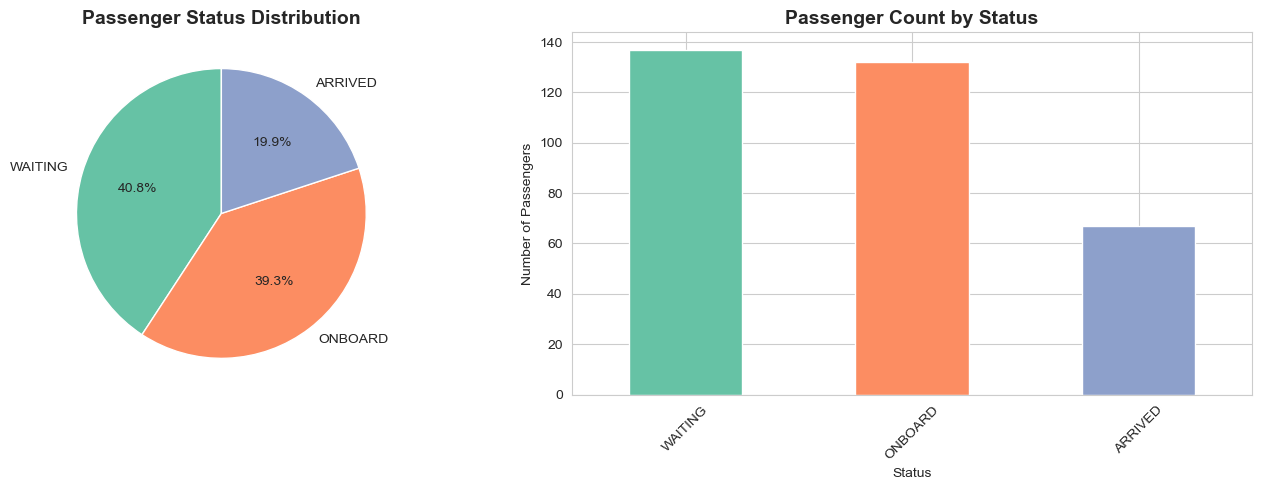

In [13]:
# Calculate basic statistics
total_passengers = len(passengers)
status_counts = passengers['status'].value_counts()
status_percentages = passengers['status'].value_counts(normalize=True) * 100

print("=" * 80)
print("PASSENGER STATUS DISTRIBUTION")
print("=" * 80)
print(f"\nTotal Passengers: {total_passengers:,}")
print("\nStatus Breakdown:")
for status in status_counts.index:
    count = status_counts[status]
    pct = status_percentages[status]
    print(f"  {status:12s}: {count:6,} ({pct:5.2f}%)")

# Calculate service rate (successfully arrived passengers)
service_rate = (status_counts.get('ARRIVED', 0) / total_passengers) * 100
abandonment_rate = (status_counts.get('ABANDONED', 0) / total_passengers) * 100

print(f"\n{'Service Rate:':<20} {service_rate:.2f}%")
print(f"{'Abandonment Rate:':<20} {abandonment_rate:.2f}%")

# Waiting time statistics by status
print("\n" + "=" * 80)
print("WAITING TIME STATISTICS BY STATUS")
print("=" * 80)
for status in passengers['status'].unique():
    subset = passengers[passengers['status'] == status]['wait_time']
    print(f"\n{status}:")
    print(f"  Count: {len(subset):,}")
    print(f"  Mean:  {subset.mean():.2f} seconds ({subset.mean()/60:.2f} minutes)")
    print(f"  Median: {subset.median():.2f} seconds")
    print(f"  Max:    {subset.max():.2f} seconds")
    print(f"  Std:    {subset.std():.2f} seconds")

# Visualization: Status distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette("Set2"))
axes[0].set_title('Passenger Status Distribution', fontsize=14, fontweight='bold')

# Bar chart
status_counts.plot(kind='bar', ax=axes[1], color=sns.color_palette("Set2"))
axes[1].set_title('Passenger Count by Status', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Passengers')
axes[1].set_xlabel('Status')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

HOURLY ABANDONMENT ANALYSIS
             total_passengers  abandoned_count  abandonment_rate  service_rate
appear_hour                                                                   
0.0                       336                0               0.0         100.0


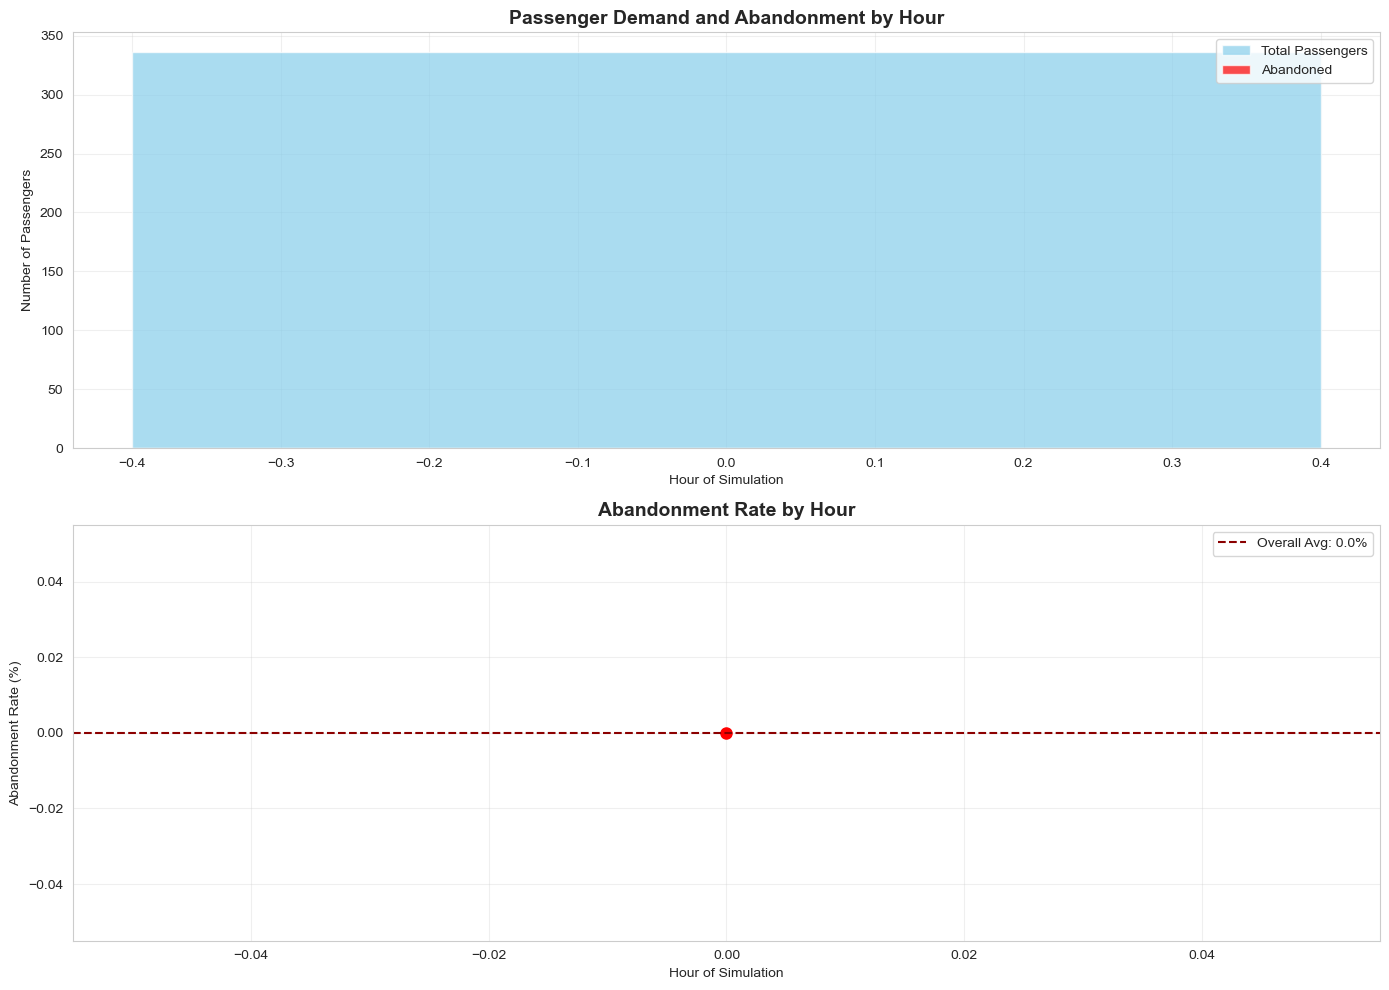


CRITICAL TIME PERIODS

Top 5 hours with highest abandonment rate:
             total_passengers  abandoned_count  abandonment_rate
appear_hour                                                     
0.0                       336                0               0.0


In [14]:
# Convert seconds to hours for temporal analysis
passengers['appear_hour'] = passengers['appear_time'] // 3600
passengers['appear_minute'] = (passengers['appear_time'] % 3600) // 60

# Analysis by hour
hourly_stats = passengers.groupby('appear_hour').agg({
    'passenger_id': 'count',
    'status': lambda x: (x == 'ABANDONED').sum()
}).rename(columns={'passenger_id': 'total_passengers', 'status': 'abandoned_count'})

hourly_stats['abandonment_rate'] = (hourly_stats['abandoned_count'] / hourly_stats['total_passengers']) * 100
hourly_stats['service_rate'] = 100 - hourly_stats['abandonment_rate']

print("=" * 80)
print("HOURLY ABANDONMENT ANALYSIS")
print("=" * 80)
print(hourly_stats.to_string())

# Visualization: Hourly patterns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Passenger demand by hour
axes[0].bar(hourly_stats.index, hourly_stats['total_passengers'], 
            color='skyblue', alpha=0.7, label='Total Passengers')
axes[0].bar(hourly_stats.index, hourly_stats['abandoned_count'], 
            color='red', alpha=0.7, label='Abandoned')
axes[0].set_xlabel('Hour of Simulation')
axes[0].set_ylabel('Number of Passengers')
axes[0].set_title('Passenger Demand and Abandonment by Hour', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Abandonment rate by hour
axes[1].plot(hourly_stats.index, hourly_stats['abandonment_rate'], 
             marker='o', linewidth=2, markersize=8, color='red')
axes[1].fill_between(hourly_stats.index, hourly_stats['abandonment_rate'], 
                      alpha=0.3, color='red')
axes[1].set_xlabel('Hour of Simulation')
axes[1].set_ylabel('Abandonment Rate (%)')
axes[1].set_title('Abandonment Rate by Hour', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=abandonment_rate, color='darkred', linestyle='--', 
                label=f'Overall Avg: {abandonment_rate:.1f}%')
axes[1].legend()

plt.tight_layout()
plt.show()

# Identify peak abandonment hours
print("\n" + "=" * 80)
print("CRITICAL TIME PERIODS")
print("=" * 80)
top_abandonment_hours = hourly_stats.nlargest(5, 'abandonment_rate')
print("\nTop 5 hours with highest abandonment rate:")
print(top_abandonment_hours[['total_passengers', 'abandoned_count', 'abandonment_rate']])

In [15]:
import json

# Load station data
with open('stations.json', 'r', encoding='utf-8') as f:
    station_data = json.load(f)

# Create station lookup dictionaries using station_id (as STRING)
station_id_to_name = {str(station['station_id']): station['name'] for station in station_data['stations']}
station_id_to_index = {str(station['station_id']): station['index'] for station in station_data['stations']}
station_index_to_name = {station['index']: station['name'] for station in station_data['stations']}

print("=" * 80)
print("STATION DATA LOADED")
print("=" * 80)
print(f"Total stations: {len(station_data['stations'])}")
print("\nStation ID to Name mapping sample:")
for i, (sid, name) in enumerate(list(station_id_to_name.items())[:5]):
    print(f"  ID {sid}: {name}")

# Convert origin and destination to string (in case they're integers)
passengers['origin'] = passengers['origin'].astype(str)
passengers['destination'] = passengers['destination'].astype(str)

# Add station names to passengers dataframe using station_id
passengers['origin_name'] = passengers['origin'].map(station_id_to_name)
passengers['destination_name'] = passengers['destination'].map(station_id_to_name)

# Check for any unmapped stations
unmapped_origins = passengers[passengers['origin_name'].isna()]['origin'].unique()
unmapped_destinations = passengers[passengers['destination_name'].isna()]['destination'].unique()

if len(unmapped_origins) > 0 or len(unmapped_destinations) > 0:
    print("\n⚠️  WARNING: Some stations could not be mapped:")
    if len(unmapped_origins) > 0:
        print(f"  Unmapped origin IDs: {unmapped_origins[:10]}...")  # Show first 10
        print(f"  Total unmapped origins: {len(unmapped_origins)}")
    if len(unmapped_destinations) > 0:
        print(f"  Unmapped destination IDs: {unmapped_destinations[:10]}...")
        print(f"  Total unmapped destinations: {len(unmapped_destinations)}")
    
    # Check if the IDs in passengers are actually in the station data
    print("\n  Available station IDs in stations.json:")
    print(f"  {list(station_id_to_name.keys())[:5]}... (first 5)")
    print(f"\n  Station IDs in passengers.csv (origin):")
    print(f"  {passengers['origin'].unique()[:5]}... (first 5)")
else:
    print("\n✓ All stations successfully mapped to names")

# Display sample with station names
print("\n" + "=" * 80)
print("PASSENGER DATA WITH STATION NAMES (Sample)")
print("=" * 80)
sample_df = passengers[['passenger_id', 'origin', 'origin_name', 'destination', 
                         'destination_name', 'status', 'wait_time']].head(10)
print(sample_df.to_string())

# Summary of mapping success
total_passengers_with_names = passengers[passengers['origin_name'].notna() & 
                                          passengers['destination_name'].notna()]
mapping_success_rate = len(total_passengers_with_names) / len(passengers) * 100
print(f"\n{'Mapping success rate:':<30} {mapping_success_rate:.1f}%")
print(f"{'Passengers with valid names:':<30} {len(total_passengers_with_names):,} / {len(passengers):,}")

STATION DATA LOADED
Total stations: 22

Station ID to Name mapping sample:
  ID 8589141: Fribourg, Chaley
  ID 8589152: Fribourg, Mon-Repos
  ID 8589138: Fribourg, Cité-Jardins
  ID 8591766: Fribourg, Boschung
  ID 8587255: Fribourg, Tilleul/Cathédrale

✓ All stations successfully mapped to names

PASSENGER DATA WITH STATION NAMES (Sample)
  passenger_id   origin                   origin_name destination             destination_name   status    wait_time
0           P1  8589141              Fribourg, Chaley     8589161          Fribourg, St-Pierre  ARRIVED   939.346394
1           P2  8589152           Fribourg, Mon-Repos     8589161          Fribourg, St-Pierre  ARRIVED   678.376305
2           P3  8589138        Fribourg, Cité-Jardins     8592374  Fribourg/Freiburg, Pl. Gare  ARRIVED  1050.112539
3           P4  8589138        Fribourg, Cité-Jardins     8592374  Fribourg/Freiburg, Pl. Gare  ARRIVED   999.233651
4           P5  8589138        Fribourg, Cité-Jardins     8592374  Fribou

ANALYSIS SCOPE
Total passengers in dataset: 336
Passengers with valid station names: 336
Passengers excluded (unmapped stations): 0

ABANDONMENT BY ORIGIN STATION (WITH NAMES)
                                total_passengers  abandoned_count  abandonment_rate
origin_name                                                                        
Fribourg, Bertigny                            11                0               0.0
Fribourg, Boschung                            20                0               0.0
Fribourg, Chaley                               5                0               0.0
Fribourg, Cité-Jardins                         9                0               0.0
Fribourg, Mon-Repos                            5                0               0.0
Fribourg, Pont-Zaehringen                      5                0               0.0
Fribourg, St-Pierre                           49                0               0.0
Fribourg, Tilleul/Cathédrale                  16                0   

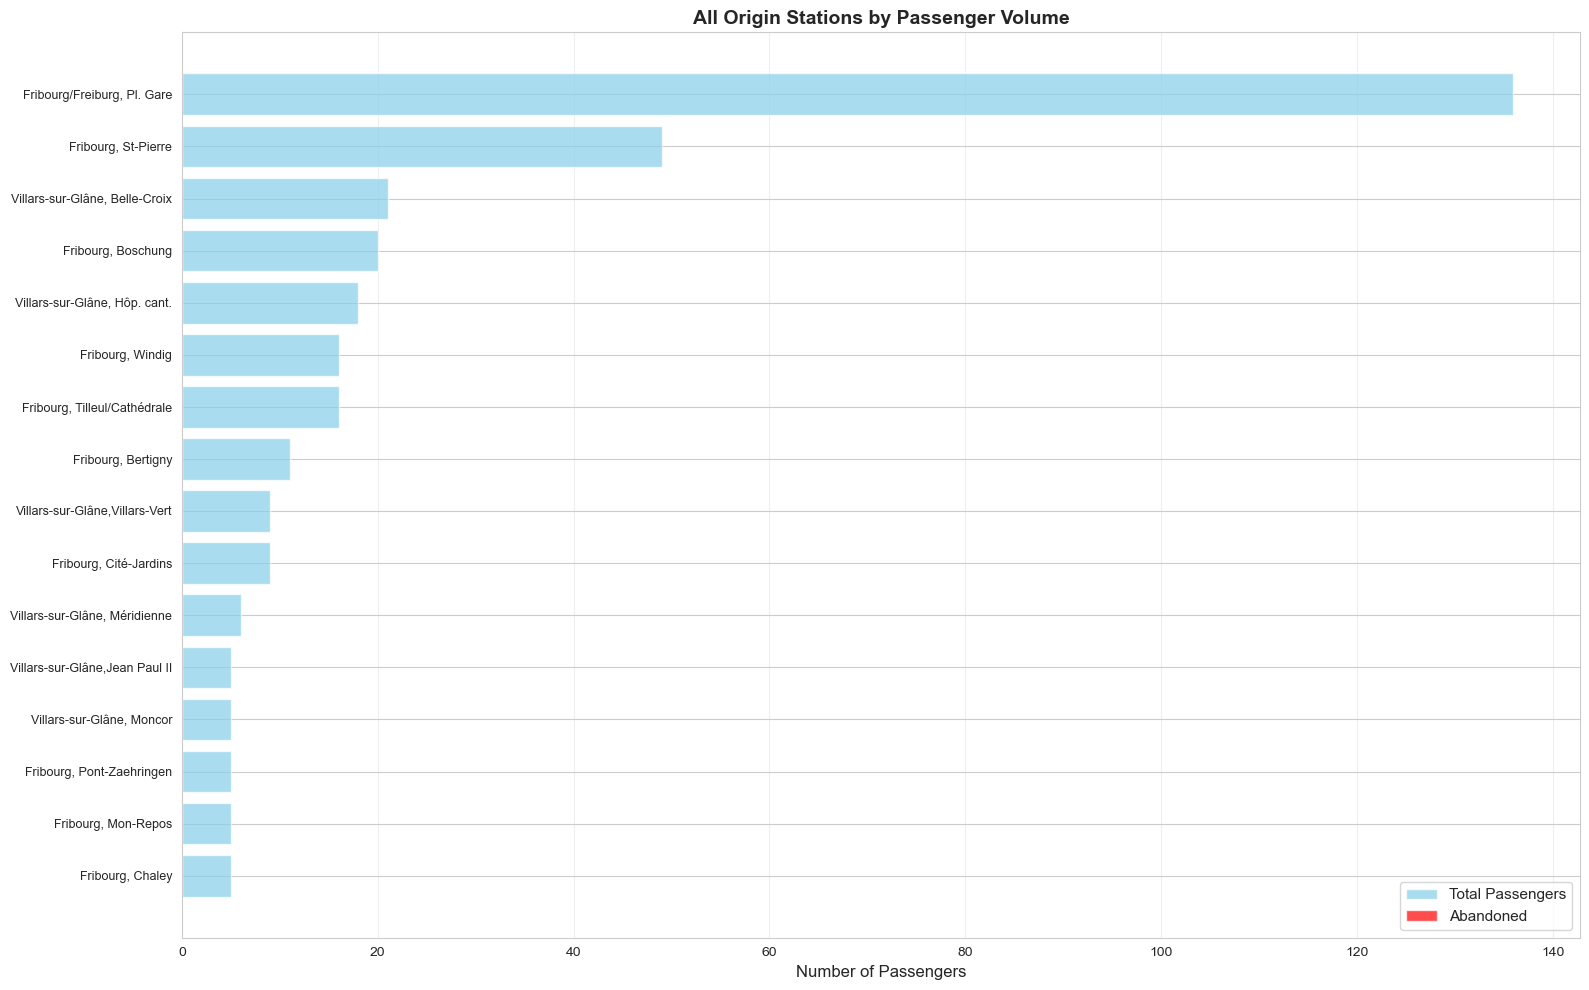

In [16]:
# Filter out passengers with unmapped stations for clean analysis
passengers_valid = passengers[passengers['origin_name'].notna() & 
                               passengers['destination_name'].notna()].copy()

print("=" * 80)
print("ANALYSIS SCOPE")
print("=" * 80)
print(f"Total passengers in dataset: {len(passengers):,}")
print(f"Passengers with valid station names: {len(passengers_valid):,}")
print(f"Passengers excluded (unmapped stations): {len(passengers) - len(passengers_valid):,}")

# Recalculate origin stats with station names
origin_stats_named = passengers_valid.groupby('origin_name').agg({
    'passenger_id': 'count',
    'status': lambda x: (x == 'ABANDONED').sum()
}).rename(columns={'passenger_id': 'total_passengers', 'status': 'abandoned_count'})

origin_stats_named['abandonment_rate'] = (origin_stats_named['abandoned_count'] / 
                                           origin_stats_named['total_passengers']) * 100
origin_stats_named = origin_stats_named.sort_values('abandonment_rate', ascending=False)

print("\n" + "=" * 80)
print("ABANDONMENT BY ORIGIN STATION (WITH NAMES)")
print("=" * 80)
print(origin_stats_named.to_string())

# Top problematic stations with names
print("\n" + "=" * 80)
print("TOP 10 MOST PROBLEMATIC STATIONS")
print("=" * 80)
top_problematic_named = origin_stats_named.nlargest(10, 'abandonment_rate')
print(top_problematic_named.to_string())

# Stations with 100% abandonment
no_service_stations_named = origin_stats_named[origin_stats_named['abandonment_rate'] == 100]
print(f"\n{'Stations with 0% service:':<30} {len(no_service_stations_named)}")
if len(no_service_stations_named) > 0:
    print(f"{'Total affected passengers:':<30} {no_service_stations_named['total_passengers'].sum()}")
    print("\nStations with NO service:")
    for station_name in no_service_stations_named.index:
        pax_count = no_service_stations_named.loc[station_name, 'total_passengers']
        print(f"  - {station_name}: {pax_count} passengers")

# Stations with best service
print("\n" + "=" * 80)
print("TOP 5 BEST PERFORMING STATIONS (lowest abandonment)")
print("=" * 80)
best_stations = origin_stats_named.nsmallest(5, 'abandonment_rate')
print(best_stations.to_string())

# Visualization: ALL stations by passenger volume
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# Sort by total passengers for better visualization
all_stations_sorted = origin_stats_named.sort_values('total_passengers', ascending=True)
y_pos = np.arange(len(all_stations_sorted))

ax.barh(y_pos, all_stations_sorted['total_passengers'], color='skyblue', 
        alpha=0.7, label='Total Passengers')
ax.barh(y_pos, all_stations_sorted['abandoned_count'], color='red', 
        alpha=0.7, label='Abandoned')
ax.set_yticks(y_pos)
ax.set_yticklabels(all_stations_sorted.index, fontsize=9)
ax.set_xlabel('Number of Passengers', fontsize=12)
ax.set_title('All Origin Stations by Passenger Volume', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

OD PAIR ANALYSIS (WITH STATION NAMES)
Total OD pairs: 42
OD pairs with 100% abandonment: 0

TOP 20 MOST PROBLEMATIC OD PAIRS
                                                                                 origin_name                destination_name  total_passengers  abandoned_count  abandonment_rate
od_pair_named                                                                                                                                                                    
Fribourg, Bertigny → Fribourg/Freiburg, Pl. Gare                          Fribourg, Bertigny     Fribourg/Freiburg, Pl. Gare                11                0               0.0
Fribourg/Freiburg, Pl. Gare → Villars-sur-Glâne, Hôp. cant.      Fribourg/Freiburg, Pl. Gare   Villars-sur-Glâne, Hôp. cant.                11                0               0.0
Fribourg/Freiburg, Pl. Gare → Fribourg, Cité-Jardins             Fribourg/Freiburg, Pl. Gare          Fribourg, Cité-Jardins                 1                0    

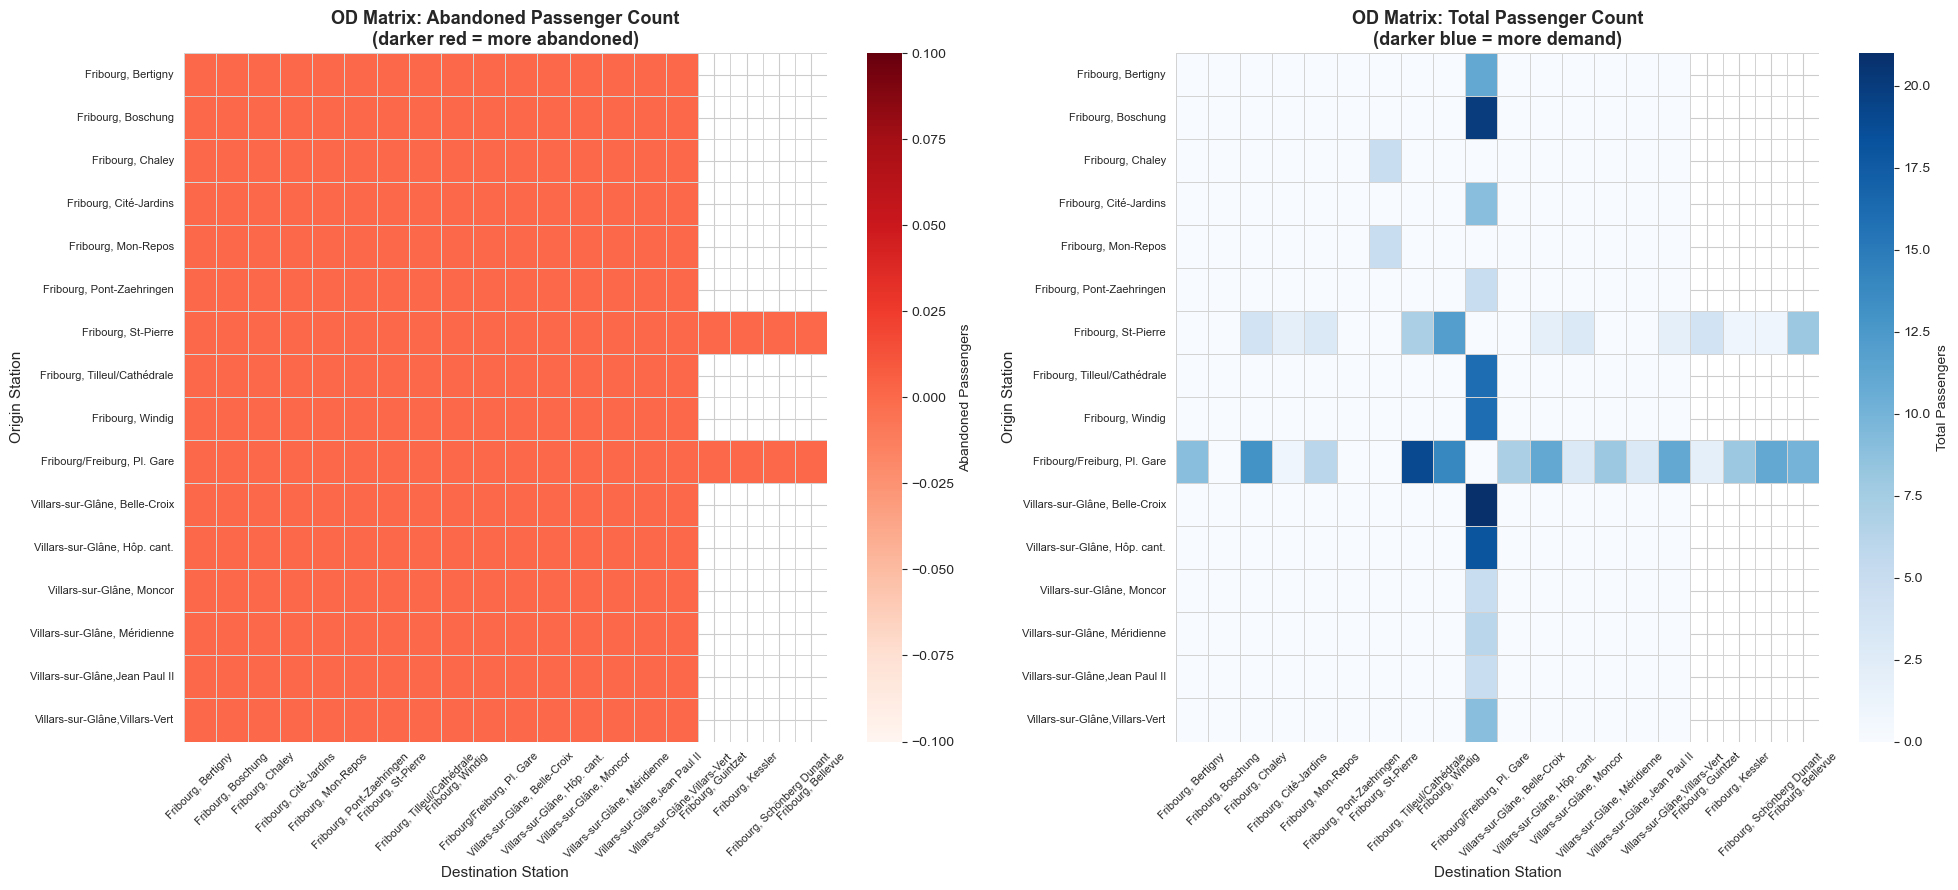

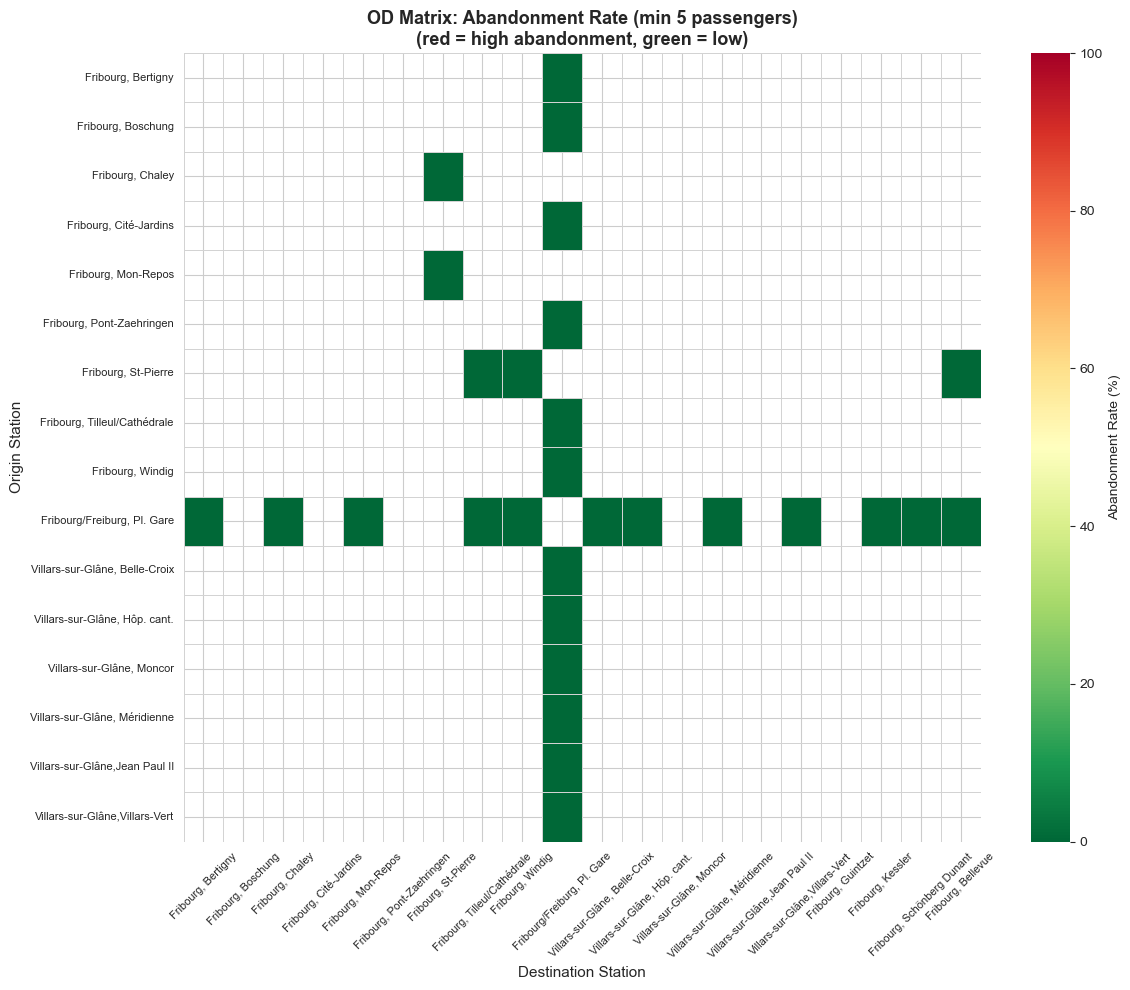

In [17]:
# Create OD pair with station names (using valid passengers only)
passengers_valid['od_pair_named'] = (passengers_valid['origin_name'] + ' → ' + 
                                      passengers_valid['destination_name'])

# Analysis by OD pair with names
od_stats_named = passengers_valid.groupby('od_pair_named').agg({
    'passenger_id': 'count',
    'status': lambda x: (x == 'ABANDONED').sum(),
    'origin_name': 'first',
    'destination_name': 'first'
}).rename(columns={'passenger_id': 'total_passengers', 'status': 'abandoned_count'})

od_stats_named['abandonment_rate'] = (od_stats_named['abandoned_count'] / 
                                       od_stats_named['total_passengers']) * 100
od_stats_named = od_stats_named.sort_values('abandonment_rate', ascending=False)

print("=" * 80)
print("OD PAIR ANALYSIS (WITH STATION NAMES)")
print("=" * 80)
print(f"Total OD pairs: {len(od_stats_named)}")
print(f"OD pairs with 100% abandonment: {len(od_stats_named[od_stats_named['abandonment_rate'] == 100])}")

# Top problematic OD pairs
print("\n" + "=" * 80)
print("TOP 20 MOST PROBLEMATIC OD PAIRS")
print("=" * 80)
top_od_named = od_stats_named.nlargest(20, 'abandonment_rate')
print(top_od_named[['origin_name', 'destination_name', 'total_passengers', 
                     'abandoned_count', 'abandonment_rate']].to_string())

# High-volume OD pairs with high abandonment
print("\n" + "=" * 80)
print("HIGH-VOLUME OD PAIRS WITH HIGH ABANDONMENT (>50%, min 10 passengers)")
print("=" * 80)
high_volume_high_abandon_named = od_stats_named[
    (od_stats_named['total_passengers'] >= 10) & 
    (od_stats_named['abandonment_rate'] > 50)
].sort_values('total_passengers', ascending=False)
print(high_volume_high_abandon_named[['origin_name', 'destination_name', 
                                       'total_passengers', 'abandoned_count', 
                                       'abandonment_rate']].head(20).to_string())

# Best performing OD pairs
print("\n" + "=" * 80)
print("TOP 10 BEST PERFORMING OD PAIRS (lowest abandonment, min 10 passengers)")
print("=" * 80)
best_od = od_stats_named[od_stats_named['total_passengers'] >= 10].nsmallest(10, 'abandonment_rate')
print(best_od[['origin_name', 'destination_name', 'total_passengers', 
               'abandoned_count', 'abandonment_rate']].to_string())

# Create OD matrix for heatmap - using abandoned passenger count
# Get unique station names in consistent order
unique_stations = sorted(passengers_valid['origin_name'].unique())

# Initialize matrices
od_matrix_abandoned = pd.DataFrame(0, index=unique_stations, columns=unique_stations)
od_matrix_total = pd.DataFrame(0, index=unique_stations, columns=unique_stations)

# Fill the matrices
for _, row in od_stats_named.iterrows():
    origin = row['origin_name']
    destination = row['destination_name']
    od_matrix_abandoned.loc[origin, destination] = row['abandoned_count']
    od_matrix_total.loc[origin, destination] = row['total_passengers']

# Visualization: OD Heatmap
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Heatmap 1: Abandoned passenger count
sns.heatmap(od_matrix_abandoned, annot=False, fmt='g', cmap='Reds', 
            cbar_kws={'label': 'Abandoned Passengers'}, ax=axes[0],
            linewidths=0.5, linecolor='lightgray')
axes[0].set_title('OD Matrix: Abandoned Passenger Count\n(darker red = more abandoned)', 
                   fontsize=13, fontweight='bold')
axes[0].set_xlabel('Destination Station', fontsize=11)
axes[0].set_ylabel('Origin Station', fontsize=11)
axes[0].tick_params(axis='x', rotation=45, labelsize=8)
axes[0].tick_params(axis='y', rotation=0, labelsize=8)

# Heatmap 2: Total passenger count (for comparison)
sns.heatmap(od_matrix_total, annot=False, fmt='g', cmap='Blues', 
            cbar_kws={'label': 'Total Passengers'}, ax=axes[1],
            linewidths=0.5, linecolor='lightgray')
axes[1].set_title('OD Matrix: Total Passenger Count\n(darker blue = more demand)', 
                   fontsize=13, fontweight='bold')
axes[1].set_xlabel('Destination Station', fontsize=11)
axes[1].set_ylabel('Origin Station', fontsize=11)
axes[1].tick_params(axis='x', rotation=45, labelsize=8)
axes[1].tick_params(axis='y', rotation=0, labelsize=8)

plt.tight_layout()
plt.show()

# Additional: Abandonment rate heatmap (only for pairs with at least 5 passengers)
od_matrix_rate = od_matrix_abandoned / od_matrix_total.replace(0, np.nan) * 100
# Mask cells with less than 5 passengers
od_matrix_rate_masked = od_matrix_rate.where(od_matrix_total >= 5)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(od_matrix_rate_masked, annot=False, fmt='.0f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Abandonment Rate (%)'}, ax=ax,
            linewidths=0.5, linecolor='lightgray', vmin=0, vmax=100,
            mask=od_matrix_rate_masked.isna())
ax.set_title('OD Matrix: Abandonment Rate (min 5 passengers)\n(red = high abandonment, green = low)', 
             fontsize=13, fontweight='bold')
ax.set_xlabel('Destination Station', fontsize=11)
ax.set_ylabel('Origin Station', fontsize=11)
ax.tick_params(axis='x', rotation=45, labelsize=8)
ax.tick_params(axis='y', rotation=0, labelsize=8)

plt.tight_layout()
plt.show()

Displaying specific vehicles: ['MINIBUS_1']


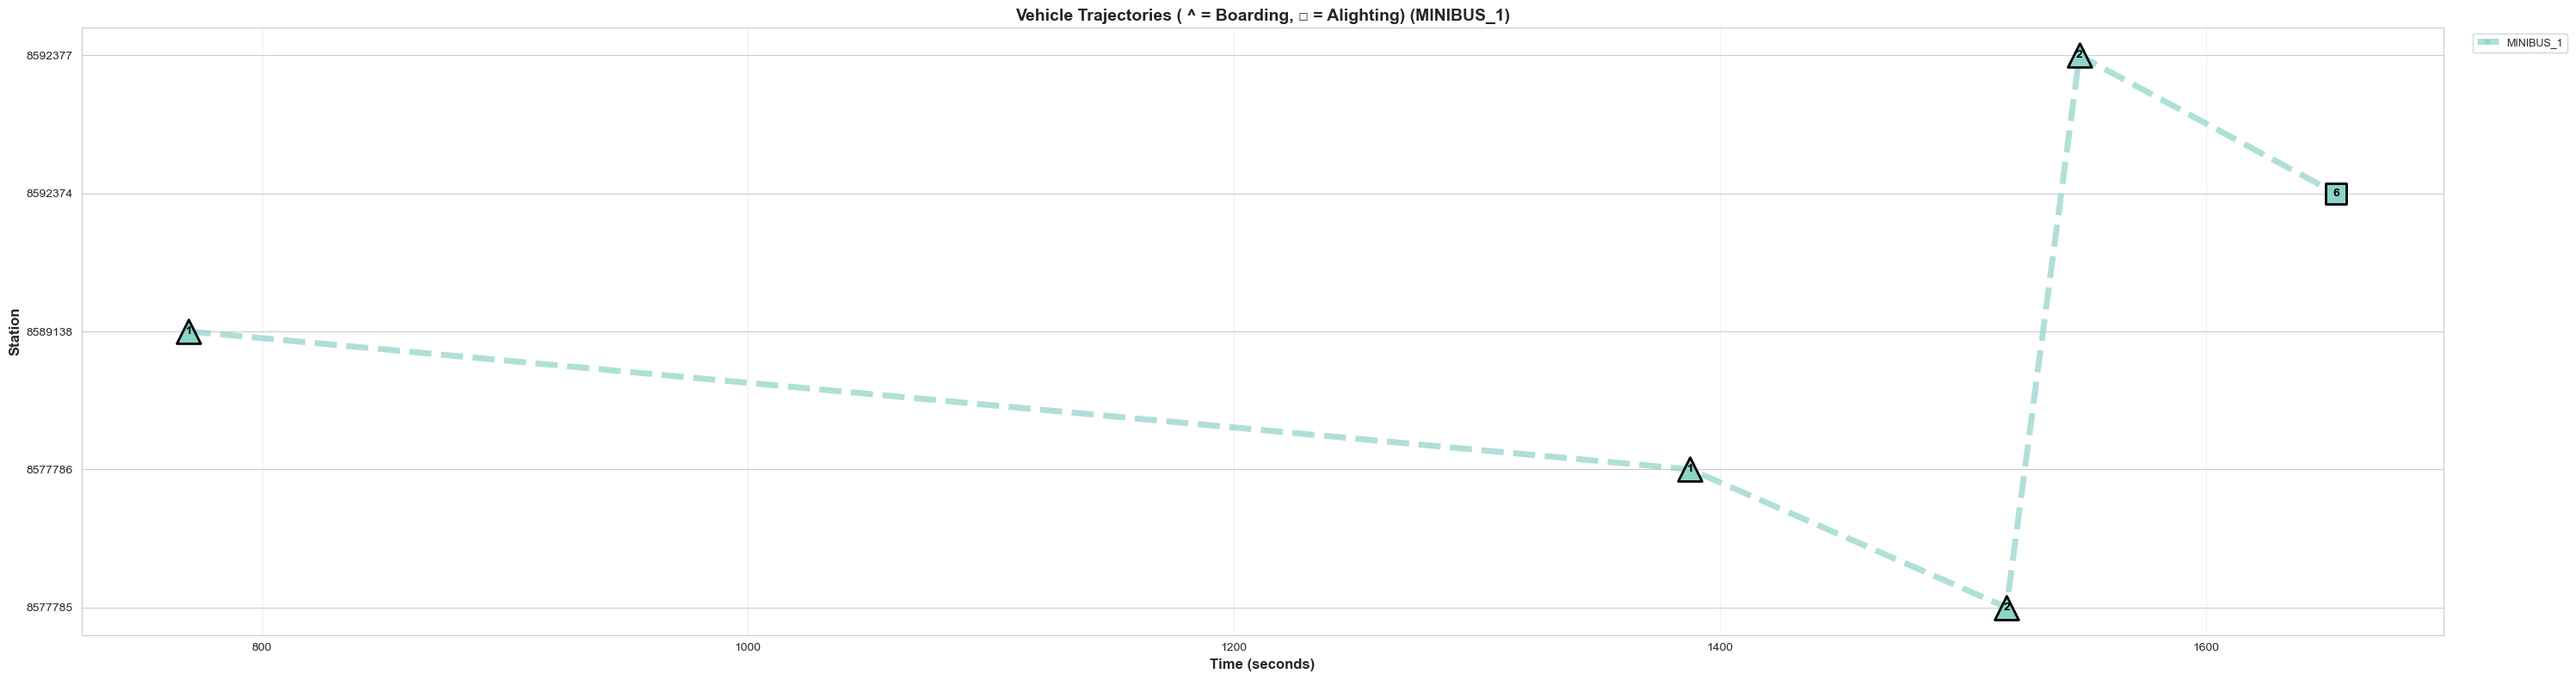

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

df = pd.read_csv('results/vehicle_states.csv')

# ============ Vehicle Filter Options ============
# Option 1: Display mode
FILTER_MODE = 'specific'  # 'all', 'minibus_only', 'specific'

# Option 2: If 'specific' is selected, specify vehicle list
SPECIFIC_VEHICLES = ['MINIBUS_1']  # Example, modify based on actual vehicle IDs

# ===============================================

# Apply vehicle filter
all_vehicles = df['vehicle_id'].unique()

if FILTER_MODE == 'minibus_only':
    vehicles = [v for v in all_vehicles if 'MINIBUS' in v]
    print(f"Displaying MINIBUS vehicles: {vehicles}")
elif FILTER_MODE == 'specific':
    vehicles = [v for v in SPECIFIC_VEHICLES if v in all_vehicles]
    print(f"Displaying specific vehicles: {vehicles}")
    if len(vehicles) == 0:
        print(f"Warning: Specified vehicles not found. Available vehicles: {list(all_vehicles)}")
else:
    vehicles = all_vehicles
    print(f"Displaying all vehicles: {list(vehicles)}")

# Filter dataframe to only include selected vehicles
df = df[df['vehicle_id'].isin(vehicles)].copy()

if len(vehicles) == 0:
    print("Error: No vehicles to display!")
    exit()

# Define station order (y-axis)
stations = sorted(df['location'].unique())
station_to_y = {s: i for i, s in enumerate(stations)}

# Map locations to y-coordinates for all events
df['y'] = df['location'].map(station_to_y)

# Create figure
fig, ax = plt.subplots(figsize=(30, 8))

# Color mapping for different vehicle types
colors = {}
for vehicle in vehicles:
    if 'MINIBUS' in vehicle:
        colors[vehicle] = plt.cm.Set3(len(colors) % 12)
    else:
        colors[vehicle] = plt.cm.Set1(len(colors) % 9)

# Plot each vehicle's trajectory
for vehicle in vehicles:
    # Get arrival events for trajectory line
    arrival_data = df[(df['vehicle_id'] == vehicle) & (df['type'] == 'ARRIVAL')].sort_values('time')
    
    if len(arrival_data) > 0:
        times = arrival_data['time'].values
        y_coords = arrival_data['y'].values
        
        # Plot line with proper zorder to ensure visibility
        linestyle = '--' if 'MINIBUS' in vehicle else '-'
        linewidth = 5 if 'MINIBUS' in vehicle else 2.5
        ax.plot(times, y_coords, marker='o', markersize=4, 
                label=vehicle, color=colors[vehicle], 
                linestyle=linestyle, linewidth=linewidth, alpha=0.7,
                zorder=4)  # Set zorder to keep lines visible below markers

# Detect overlapping events and assign offsets
# Group events by (time, location) to detect overlaps
event_data = df[(df['type'].isin(['BOARDING', 'ALIGHTING'])) & (df['count'] > 0)].copy()
position_groups = defaultdict(list)

for idx, row in event_data.iterrows():
    key = (row['time'], row['y'])
    position_groups[key].append((idx, row))

# Assign x-offsets for overlapping events
offset_scale = 15  # Horizontal offset in time units
offsets = {}

for key, events in position_groups.items():
    if len(events) == 1:
        offsets[events[0][0]] = 0
    else:
        # Distribute events horizontally
        n = len(events)
        for i, (idx, row) in enumerate(events):
            offset = (i - (n-1)/2) * offset_scale
            offsets[idx] = offset

# Plot boarding and alighting events with offsets
for vehicle in vehicles:
    # Get boarding events (triangles)
    boarding_data = df[(df['vehicle_id'] == vehicle) & (df['type'] == 'BOARDING')]
    for idx, row in boarding_data.iterrows():
        if pd.notna(row['count']) and row['count'] > 0:
            x_offset = offsets.get(idx, 0)
            # Plot triangle markers with higher zorder to appear above lines
            ax.scatter(row['time'] + x_offset, row['y'], marker='^', s=400, 
                      color=colors[vehicle], edgecolors='black', linewidths=2, zorder=10)
            # Add count text on top of markers
            ax.text(row['time'] + x_offset, row['y'], str(int(row['count'])), 
                   fontsize=10, fontweight='bold', ha='center', va='center',
                   color='black', zorder=11)
    
    # Get alighting events (squares)
    alighting_data = df[(df['vehicle_id'] == vehicle) & (df['type'] == 'ALIGHTING')]
    for idx, row in alighting_data.iterrows():
        if pd.notna(row['count']) and row['count'] > 0:
            x_offset = offsets.get(idx, 0)
            # Plot square markers with higher zorder to appear above lines
            ax.scatter(row['time'] + x_offset, row['y'], marker='s', s=300, 
                      color=colors[vehicle], edgecolors='black', linewidths=2, zorder=10)
            # Add count text on top of markers
            ax.text(row['time'] + x_offset, row['y'], str(int(row['count'])), 
                   fontsize=10, fontweight='bold', ha='center', va='center',
                   color='black', zorder=11)

# Configure axes
ax.set_yticks(range(len(stations)))
ax.set_yticklabels(stations)
ax.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Station', fontsize=12, fontweight='bold')

# Update title based on filter mode
if FILTER_MODE == 'minibus_only':
    title_suffix = ' (MINIBUS Only)'
elif FILTER_MODE == 'specific':
    title_suffix = f' ({", ".join(vehicles)})'
else:
    title_suffix = ''
ax.set_title(f'Vehicle Trajectories ( ^ = Boarding, □ = Alighting){title_suffix}', 
             fontsize=14, fontweight='bold')

ax.grid(True, alpha=0.3, axis='x')
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=9, ncol=1)

plt.tight_layout()
# plt.savefig('vehicle_trajectories.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Plot saved as 'vehicle_trajectories.png'")

Displaying specific vehicles: ['MINIBUS_3']


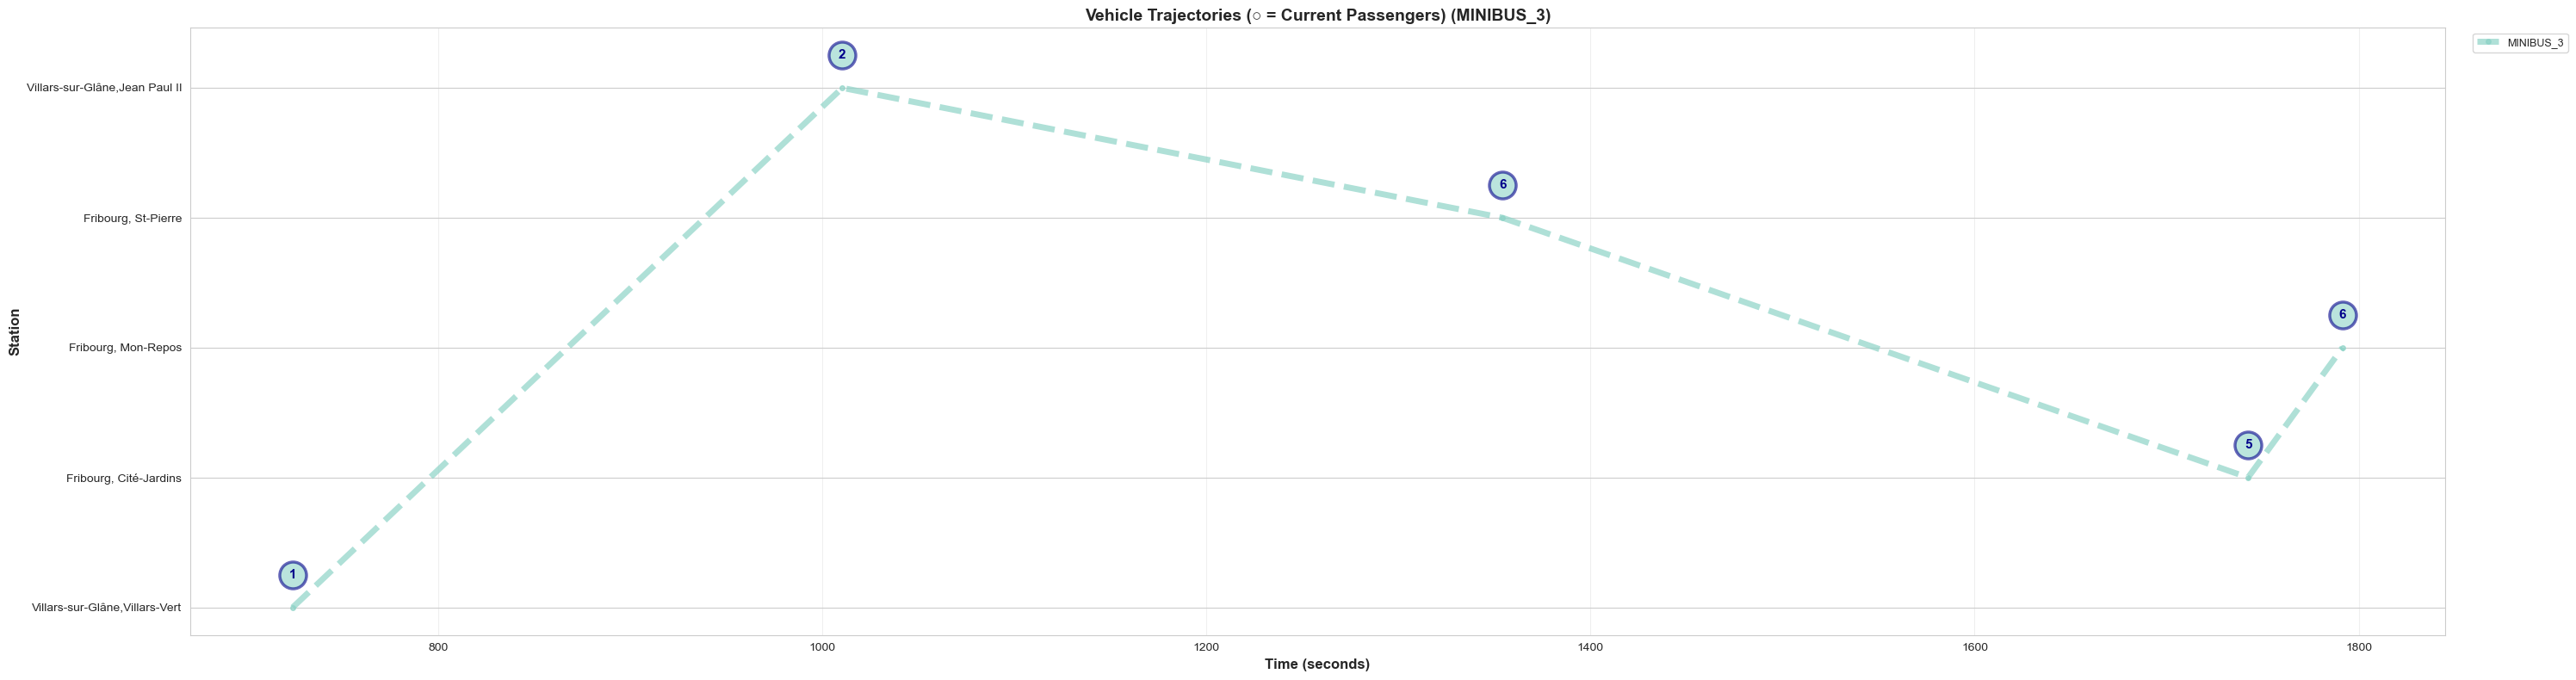

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

df = pd.read_csv('results/vehicle_states.csv')

# ============ Vehicle Filter Options ============
# Option 1: Display mode
FILTER_MODE = 'specific'  # 'all', 'minibus_only', 'specific'

# Option 2: If 'specific' is selected, specify vehicle list
SPECIFIC_VEHICLES = ['MINIBUS_3']  # Example, modify based on actual vehicle IDs

# ===============================================

# Apply vehicle filter
all_vehicles = df['vehicle_id'].unique()

if FILTER_MODE == 'minibus_only':
    vehicles = [v for v in all_vehicles if 'MINIBUS' in v]
    print(f"Displaying MINIBUS vehicles: {vehicles}")
elif FILTER_MODE == 'specific':
    vehicles = [v for v in SPECIFIC_VEHICLES if v in all_vehicles]
    print(f"Displaying specific vehicles: {vehicles}")
    if len(vehicles) == 0:
        print(f"Warning: Specified vehicles not found. Available vehicles: {list(all_vehicles)}")
else:
    vehicles = all_vehicles
    print(f"Displaying all vehicles: {list(vehicles)}")

# Filter dataframe to only include selected vehicles
df = df[df['vehicle_id'].isin(vehicles)].copy()

if len(vehicles) == 0:
    print("Error: No vehicles to display!")
    exit()

# Create mapping from station_id to station name
station_id_to_name = {s['station_id']: s['name'] for s in station_data['stations']}

# Define station order (y-axis) using station IDs
stations = sorted(df['location'].unique())
station_to_y = {s: i for i, s in enumerate(stations)}

# Map locations to y-coordinates for all events
df['y'] = df['location'].map(station_to_y)

# Create figure
fig, ax = plt.subplots(figsize=(30, 8))

# Color mapping for different vehicle types
colors = {}
for vehicle in vehicles:
    if 'MINIBUS' in vehicle:
        colors[vehicle] = plt.cm.Set3(len(colors) % 12)
    else:
        colors[vehicle] = plt.cm.Set1(len(colors) % 9)

# Calculate current passenger count for each vehicle at each event
vehicle_occupancy = {}

for vehicle in vehicles:
    vehicle_data = df[df['vehicle_id'] == vehicle].sort_values('time')
    current_passengers = 0
    occupancy_records = []
    
    for idx, row in vehicle_data.iterrows():
        if row['type'] == 'BOARDING' and pd.notna(row['count']):
            current_passengers += int(row['count'])
            occupancy_records.append({
                'time': row['time'],
                'y': row['y'],
                'passengers': current_passengers,
                'event_type': 'BOARDING'
            })
        elif row['type'] == 'ALIGHTING' and pd.notna(row['count']):
            current_passengers -= int(row['count'])
            occupancy_records.append({
                'time': row['time'],
                'y': row['y'],
                'passengers': current_passengers,
                'event_type': 'ALIGHTING'
            })
    
    vehicle_occupancy[vehicle] = occupancy_records

# Plot each vehicle's trajectory
for vehicle in vehicles:
    # Get arrival events for trajectory line
    arrival_data = df[(df['vehicle_id'] == vehicle) & (df['type'] == 'ARRIVAL')].sort_values('time')
    
    if len(arrival_data) > 0:
        times = arrival_data['time'].values
        y_coords = arrival_data['y'].values
        
        # Plot line
        linestyle = '--' if 'MINIBUS' in vehicle else '-'
        linewidth = 5 if 'MINIBUS' in vehicle else 2.5
        ax.plot(times, y_coords, marker='o', markersize=4, 
                label=vehicle, color=colors[vehicle], 
                linestyle=linestyle, linewidth=linewidth, alpha=0.7)

# Detect overlapping events and assign offsets
# Group events by (time, location) to detect overlaps
event_data = df[(df['type'].isin(['BOARDING', 'ALIGHTING'])) & (df['count'] > 0)].copy()
position_groups = defaultdict(list)

for idx, row in event_data.iterrows():
    key = (row['time'], row['y'])
    position_groups[key].append((idx, row))

# Assign x-offsets for overlapping events
offset_scale = 15  # Horizontal offset in time units
offsets = {}

for key, events in position_groups.items():
    if len(events) == 1:
        offsets[events[0][0]] = 0
    else:
        # Distribute events horizontally
        n = len(events)
        for i, (idx, row) in enumerate(events):
            offset = (i - (n-1)/2) * offset_scale
            offsets[idx] = offset

# Plot current passenger count as circles after each boarding/alighting event
y_offset = 0.25  # Vertical offset for occupancy circles

for vehicle in vehicles:
    occupancy_records = vehicle_occupancy[vehicle]
    
    for record in occupancy_records:
        # Find the corresponding offset for this event
        event_df = df[(df['vehicle_id'] == vehicle) & 
                     (df['time'] == record['time']) & 
                     (df['y'] == record['y']) & 
                     (df['type'] == record['event_type'])]
        
        x_offset = 0
        if not event_df.empty:
            idx = event_df.index[0]
            x_offset = offsets.get(idx, 0)
        
        # Draw circle with current passenger count
        circle_y = record['y'] + y_offset
        ax.scatter(record['time'] + x_offset, circle_y, marker='o', s=500, 
                  color=colors[vehicle], edgecolors='darkblue', linewidths=2.5, 
                  zorder=4, alpha=0.6)
        ax.text(record['time'] + x_offset, circle_y, str(record['passengers']), 
               fontsize=11, fontweight='bold', ha='center', va='center',
               color='darkblue', zorder=7)

# Configure axes with station names
station_names = [station_id_to_name.get(str(station_id), str(station_id)) for station_id in stations]
ax.set_yticks(range(len(stations)))
ax.set_yticklabels(station_names)
ax.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Station', fontsize=12, fontweight='bold')

# Update title based on filter mode
if FILTER_MODE == 'minibus_only':
    title_suffix = ' (MINIBUS Only)'
elif FILTER_MODE == 'specific':
    title_suffix = f' ({", ".join(vehicles)})'
else:
    title_suffix = ''
ax.set_title(f'Vehicle Trajectories (○ = Current Passengers){title_suffix}', 
             fontsize=14, fontweight='bold')

ax.grid(True, alpha=0.3, axis='x')
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=9, ncol=1)

plt.tight_layout()
# plt.savefig('vehicle_trajectories.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Plot saved as 'vehicle_trajectories.png'")

Displaying specific vehicles: ['MINIBUS_3']


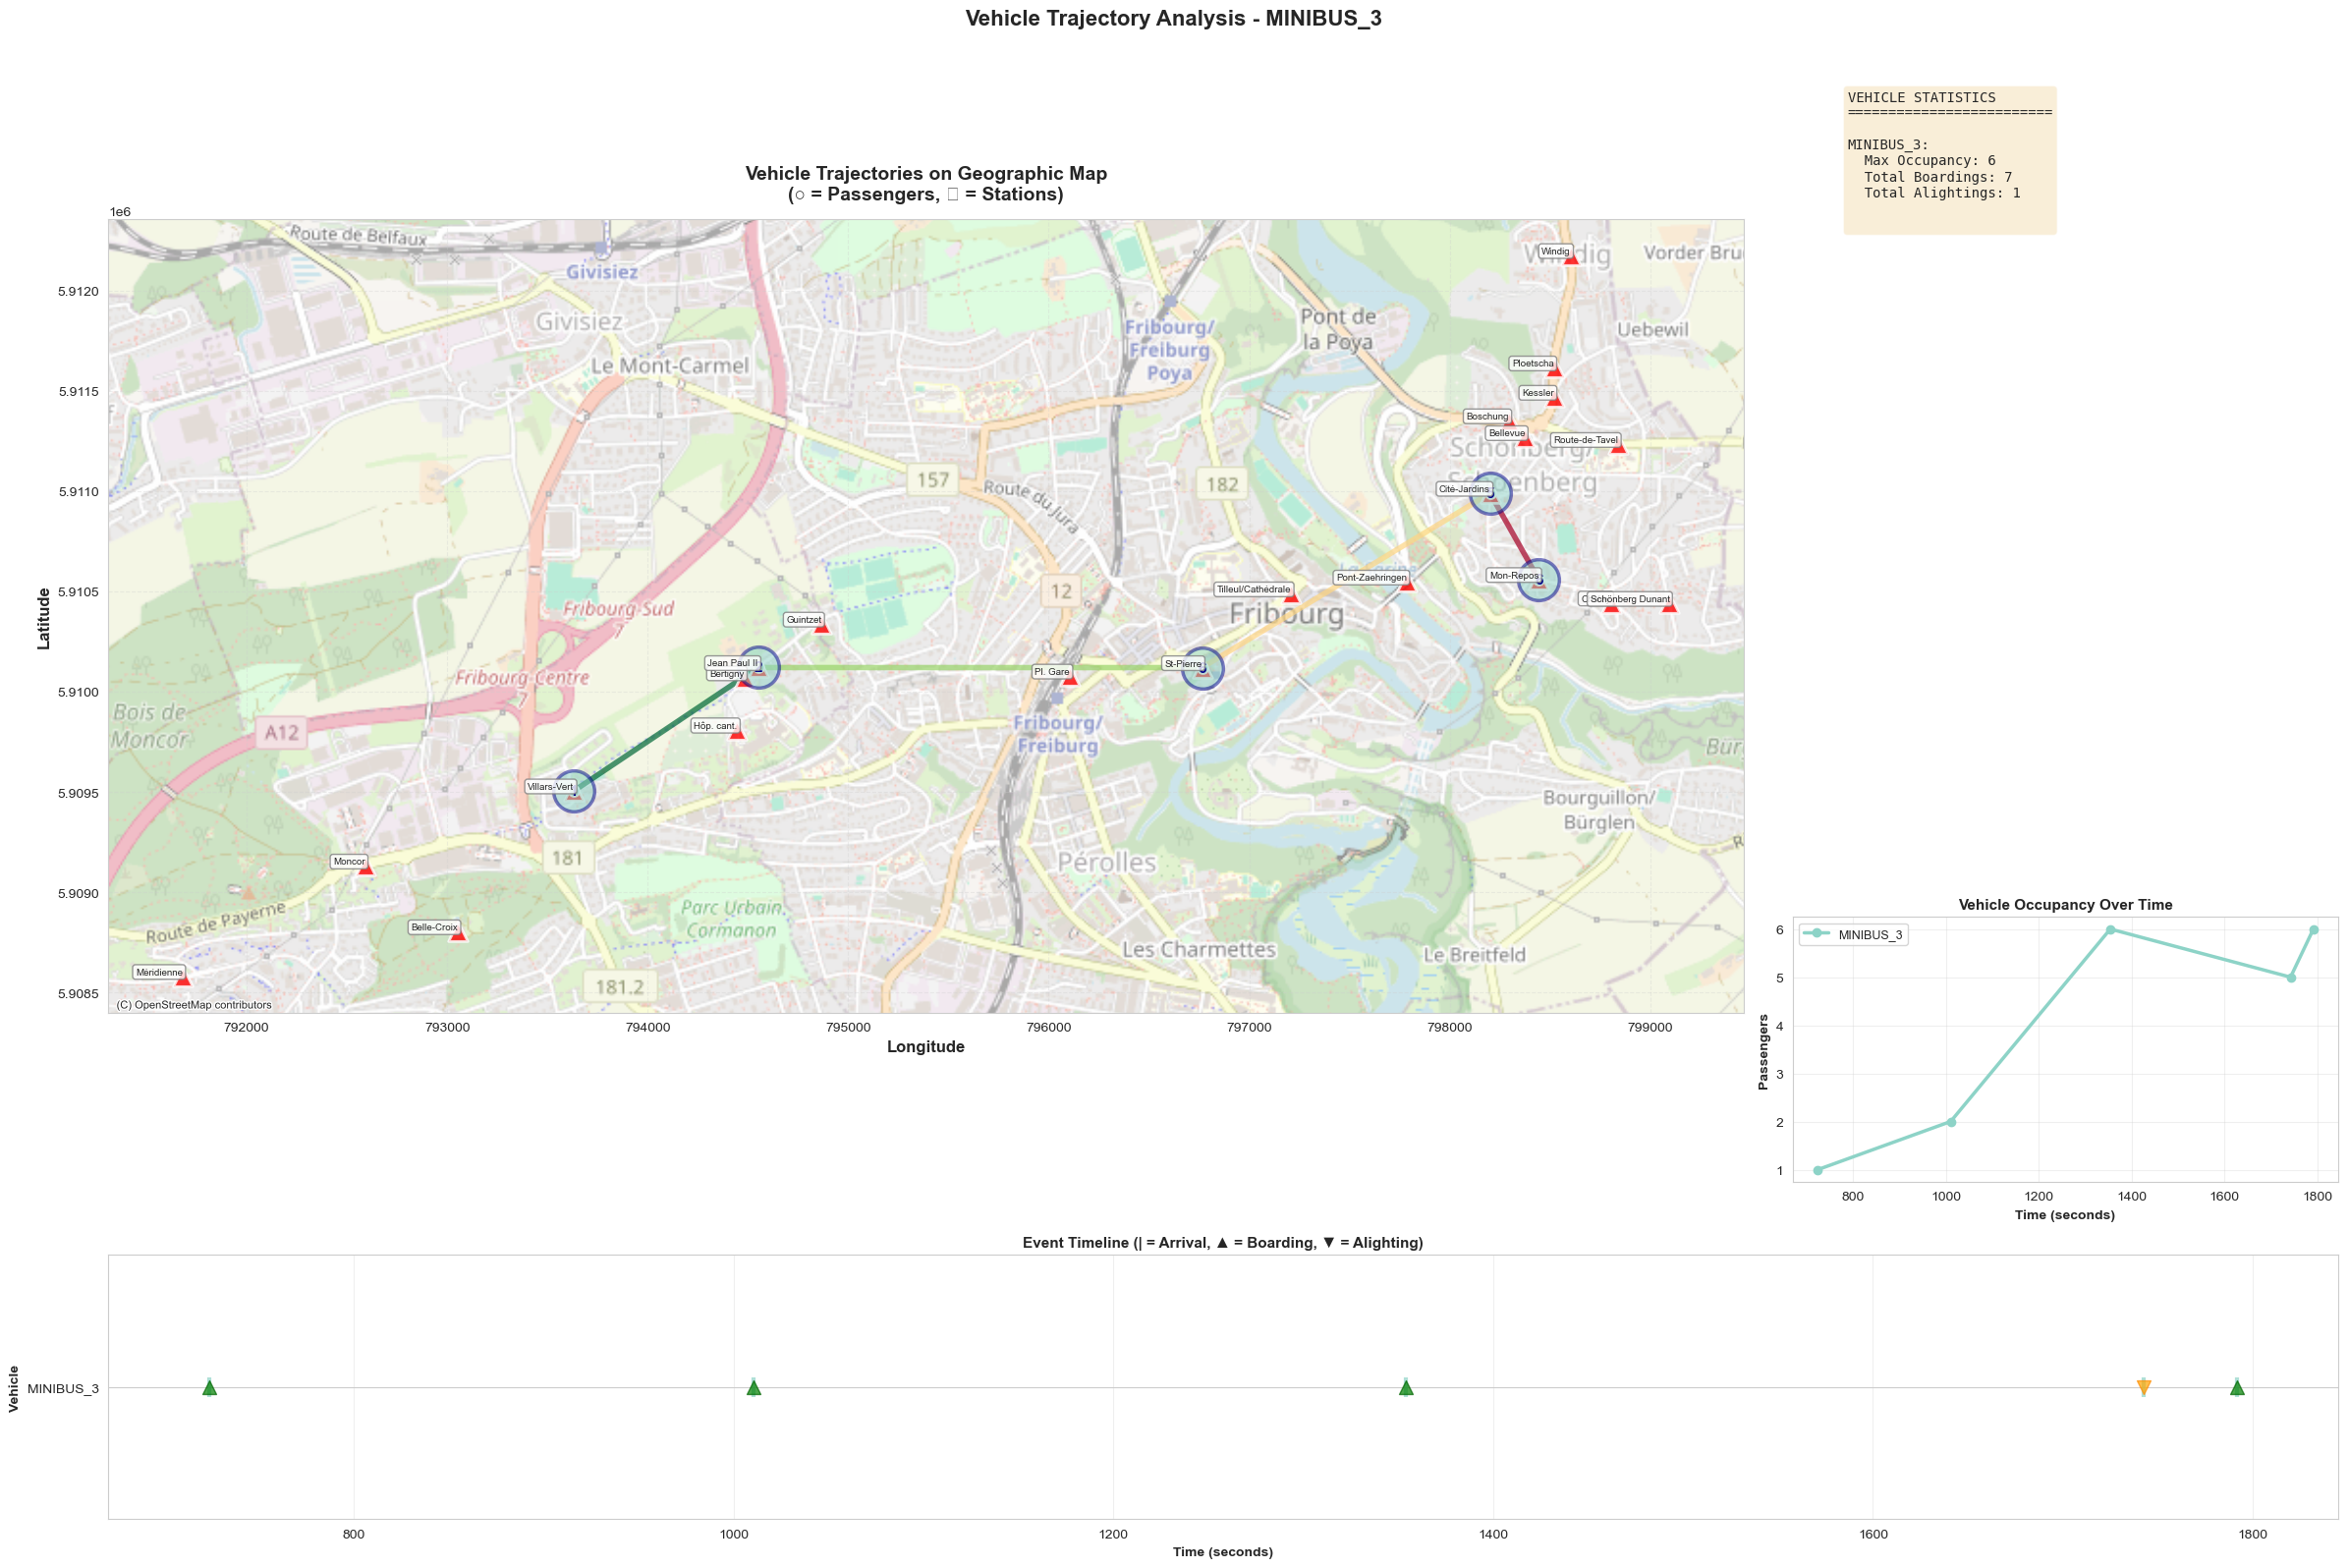


SUMMARY
Total vehicles displayed: 1
Total stations: 22

Vehicle Statistics:
  MINIBUS_3:
    - Maximum occupancy: 6 passengers
    - Total boardings: 7
    - Total alightings: 1


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point, LineString
from matplotlib.patches import FancyBboxPatch, Circle
from matplotlib.collections import LineCollection


# Create mapping dictionary from station_id to coordinates
station_coords = {s['station_id']: {'lat': s['location'][0], 'lon': s['location'][1], 'name': s['name']} 
                  for s in station_data['stations']}

# Load vehicle trajectory data
df = pd.read_csv('results/vehicle_states.csv')

# ============ Vehicle Filter Options ============
FILTER_MODE = 'specific'  # 'all', 'minibus_only', 'specific'
SPECIFIC_VEHICLES = ['MINIBUS_3']  # Specify vehicle IDs
SHOW_TIME_GRADIENT = True  # Show trajectory with time-based color gradient

# Apply vehicle filter
all_vehicles = df['vehicle_id'].unique()

if FILTER_MODE == 'minibus_only':
    vehicles = [v for v in all_vehicles if 'MINIBUS' in v]
    print(f"Displaying MINIBUS vehicles: {vehicles}")
elif FILTER_MODE == 'specific':
    vehicles = [v for v in SPECIFIC_VEHICLES if v in all_vehicles]
    print(f"Displaying specific vehicles: {vehicles}")
    if len(vehicles) == 0:
        print(f"Warning: Specified vehicles not found. Available vehicles: {list(all_vehicles)}")
else:
    vehicles = all_vehicles
    print(f"Displaying all vehicles: {list(vehicles)}")

# Filter dataframe to selected vehicles
df = df[df['vehicle_id'].isin(vehicles)].copy()

if len(vehicles) == 0:
    print("Error: No vehicles to display!")
    exit()

# Map station IDs to coordinates
df['lat'] = df['location'].map(lambda x: station_coords.get(str(x), {}).get('lat'))
df['lon'] = df['location'].map(lambda x: station_coords.get(str(x), {}).get('lon'))

# Remove rows without valid coordinates
df = df.dropna(subset=['lat', 'lon'])

# Create GeoDataFrame for stations
station_points = []
station_names = []
station_ids = []
for station_id, info in station_coords.items():
    station_points.append(Point(info['lon'], info['lat']))
    station_names.append(info['name'])
    station_ids.append(station_id)

stations_gdf = gpd.GeoDataFrame({
    'station_id': station_ids,
    'name': station_names,
    'geometry': station_points
}, crs='EPSG:4326')

# Convert to Web Mercator for contextily
stations_gdf = stations_gdf.to_crs('EPSG:3857')

# Calculate passenger counts and statistics
vehicle_occupancy = {}
vehicle_stats = {}

for vehicle in vehicles:
    vehicle_data = df[df['vehicle_id'] == vehicle].sort_values('time')
    current_passengers = 0
    occupancy_records = []
    max_occupancy = 0
    total_boardings = 0
    total_alightings = 0
    
    for idx, row in vehicle_data.iterrows():
        if row['type'] == 'BOARDING' and pd.notna(row['count']):
            boarding_count = int(row['count'])
            current_passengers += boarding_count
            total_boardings += boarding_count
            max_occupancy = max(max_occupancy, current_passengers)
            occupancy_records.append({
                'time': row['time'],
                'lat': row['lat'],
                'lon': row['lon'],
                'passengers': current_passengers,
                'event_type': 'BOARDING',
                'station_name': station_coords.get(str(row['location']), {}).get('name', 'Unknown')
            })
        elif row['type'] == 'ALIGHTING' and pd.notna(row['count']):
            alighting_count = int(row['count'])
            current_passengers -= alighting_count
            total_alightings += alighting_count
            occupancy_records.append({
                'time': row['time'],
                'lat': row['lat'],
                'lon': row['lon'],
                'passengers': current_passengers,
                'event_type': 'ALIGHTING',
                'station_name': station_coords.get(str(row['location']), {}).get('name', 'Unknown')
            })
    
    vehicle_occupancy[vehicle] = occupancy_records
    vehicle_stats[vehicle] = {
        'max_occupancy': max_occupancy,
        'total_boardings': total_boardings,
        'total_alightings': total_alightings
    }

# Create figure with subplots
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(3, 2, height_ratios=[3, 1, 1], width_ratios=[3, 1])
ax_map = fig.add_subplot(gs[0:2, 0])
ax_stats = fig.add_subplot(gs[0, 1])
ax_occupancy = fig.add_subplot(gs[1, 1])
ax_timeline = fig.add_subplot(gs[2, :])

# Color mapping for different vehicle types
colors = {}
for vehicle in vehicles:
    if 'MINIBUS' in vehicle:
        colors[vehicle] = plt.cm.Set3(len(colors) % 12)
    else:
        colors[vehicle] = plt.cm.Set1(len(colors) % 9)

# ========== MAIN MAP PLOT ==========
# Plot vehicle trajectories with time gradient
for vehicle in vehicles:
    arrival_data = df[(df['vehicle_id'] == vehicle) & (df['type'] == 'ARRIVAL')].sort_values('time')
    
    if len(arrival_data) > 1:
        # Create points in Web Mercator
        points = [Point(lon, lat) for lon, lat in zip(arrival_data['lon'].values, arrival_data['lat'].values)]
        points_gdf = gpd.GeoDataFrame({'geometry': points}, crs='EPSG:4326')
        points_gdf = points_gdf.to_crs('EPSG:3857')
        
        if SHOW_TIME_GRADIENT:
            # Create line segments with time-based colors
            segments = []
            for i in range(len(points_gdf) - 1):
                segments.append([(points_gdf.geometry.iloc[i].x, points_gdf.geometry.iloc[i].y),
                               (points_gdf.geometry.iloc[i+1].x, points_gdf.geometry.iloc[i+1].y)])
            
            # Normalize times for color mapping
            times = arrival_data['time'].values
            time_normalized = (times - times.min()) / (times.max() - times.min() + 1e-10)
            
            # Create LineCollection with gradient from green to red
            lc = LineCollection(segments, cmap='RdYlGn_r', linewidth=4, alpha=0.7)
            lc.set_array(time_normalized[:-1])
            ax_map.add_collection(lc)
        else:
            # Simple trajectory line
            coords = [(point.x, point.y) for point in points_gdf.geometry]
            trajectory_line = LineString(coords)
            trajectory_gdf = gpd.GeoDataFrame({'geometry': [trajectory_line]}, crs='EPSG:3857')
            
            linestyle = '--' if 'MINIBUS' in vehicle else '-'
            linewidth = 4 if 'MINIBUS' in vehicle else 2.5
            trajectory_gdf.plot(ax=ax_map, color=colors[vehicle], linestyle=linestyle, 
                               linewidth=linewidth, alpha=0.7, label=vehicle)
        
        # Plot arrival points
        points_gdf.plot(ax=ax_map, color=colors[vehicle], markersize=60, alpha=0.8, 
                       edgecolor='white', linewidth=1.5, zorder=3)

# Plot occupancy information with offset for overlapping visits
for vehicle in vehicles:
    occupancy_records = vehicle_occupancy[vehicle]
    
    if occupancy_records:
        # Group records by station to detect overlaps
        station_visits = defaultdict(list)
        for rec in occupancy_records:
            key = (rec['lat'], rec['lon'])
            station_visits[key].append(rec)
        
        # Add offset for multiple visits to same station
        offset_distance = 0.002  # Adjust this value to control spacing
        
        for station_key, visits in station_visits.items():
            n_visits = len(visits)
            for i, rec in enumerate(visits):
                # Calculate offset (spread around the station)
                if n_visits > 1:
                    angle = (i / n_visits) * 2 * np.pi
                    lon_offset = offset_distance * np.cos(angle)
                    lat_offset = offset_distance * np.sin(angle)
                else:
                    lon_offset = 0
                    lat_offset = 0
                
                # Create point with offset
                point = Point(rec['lon'] + lon_offset, rec['lat'] + lat_offset)
                point_gdf = gpd.GeoDataFrame({'geometry': [point]}, crs='EPSG:4326')
                point_gdf = point_gdf.to_crs('EPSG:3857')
                
                # Plot circle
                point_gdf.plot(ax=ax_map, color=colors[vehicle], markersize=900, 
                              alpha=0.5, edgecolor='darkblue', linewidth=2.5, zorder=4)
                
                # Add text label
                ax_map.text(point_gdf.geometry.iloc[0].x, point_gdf.geometry.iloc[0].y, 
                           str(rec['passengers']), 
                           fontsize=11, fontweight='bold', ha='center', va='center',
                           color='darkblue', zorder=5)

# Plot station markers
stations_gdf.plot(ax=ax_map, color='red', markersize=200, alpha=0.8, 
                 edgecolor='white', linewidth=2, zorder=2, marker='^')

# Add station labels
for idx, row in stations_gdf.iterrows():
    name_parts = row['name'].split(',')
    short_name = name_parts[-1].strip() if len(name_parts) > 1 else row['name']
    
    ax_map.text(row.geometry.x, row.geometry.y, short_name, 
               fontsize=7, ha='right', va='bottom',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                        edgecolor='gray', alpha=0.8),
               zorder=6)

# Add basemap
ctx.add_basemap(ax_map, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.6)

ax_map.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax_map.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax_map.set_title('Vehicle Trajectories on Geographic Map\n(○ = Passengers, △ = Stations)', 
                fontsize=14, fontweight='bold', pad=15)
ax_map.grid(True, alpha=0.3, linestyle='--')

# ========== STATISTICS PANEL ==========
ax_stats.axis('off')
stats_text = "VEHICLE STATISTICS\n" + "="*25 + "\n\n"
for vehicle in vehicles:
    stats = vehicle_stats[vehicle]
    stats_text += f"{vehicle}:\n"
    stats_text += f"  Max Occupancy: {stats['max_occupancy']}\n"
    stats_text += f"  Total Boardings: {stats['total_boardings']}\n"
    stats_text += f"  Total Alightings: {stats['total_alightings']}\n\n"

ax_stats.text(0.1, 0.95, stats_text, fontsize=10, verticalalignment='top',
             fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ========== OCCUPANCY OVER TIME ==========
for vehicle in vehicles:
    occupancy_records = vehicle_occupancy[vehicle]
    if occupancy_records:
        times = [rec['time'] for rec in occupancy_records]
        passengers = [rec['passengers'] for rec in occupancy_records]
        ax_occupancy.plot(times, passengers, marker='o', label=vehicle, 
                         color=colors[vehicle], linewidth=2.5, markersize=6)

ax_occupancy.set_xlabel('Time (seconds)', fontsize=10, fontweight='bold')
ax_occupancy.set_ylabel('Passengers', fontsize=10, fontweight='bold')
ax_occupancy.set_title('Vehicle Occupancy Over Time', fontsize=11, fontweight='bold')
ax_occupancy.grid(True, alpha=0.3)
ax_occupancy.legend(fontsize=9)

# ========== TIMELINE VIEW ==========
for vehicle in vehicles:
    vehicle_events = df[df['vehicle_id'] == vehicle].sort_values('time')
    
    # Plot arrival events
    arrivals = vehicle_events[vehicle_events['type'] == 'ARRIVAL']
    if len(arrivals) > 0:
        ax_timeline.scatter(arrivals['time'], [vehicle]*len(arrivals), 
                          marker='|', s=200, color=colors[vehicle], alpha=0.7, linewidths=3)
    
    # Highlight boarding/alighting events
    boardings = vehicle_events[vehicle_events['type'] == 'BOARDING']
    alightings = vehicle_events[vehicle_events['type'] == 'ALIGHTING']
    
    if len(boardings) > 0:
        ax_timeline.scatter(boardings['time'], [vehicle]*len(boardings), 
                          marker='^', s=100, color='green', alpha=0.7, edgecolors='darkgreen')
    
    if len(alightings) > 0:
        ax_timeline.scatter(alightings['time'], [vehicle]*len(alightings), 
                          marker='v', s=100, color='orange', alpha=0.7, edgecolors='darkorange')

ax_timeline.set_xlabel('Time (seconds)', fontsize=10, fontweight='bold')
ax_timeline.set_ylabel('Vehicle', fontsize=10, fontweight='bold')
ax_timeline.set_title('Event Timeline (| = Arrival, ▲ = Boarding, ▼ = Alighting)', 
                     fontsize=11, fontweight='bold')
ax_timeline.grid(True, alpha=0.3, axis='x')
ax_timeline.set_yticks(range(len(vehicles)))
ax_timeline.set_yticklabels(vehicles)

plt.suptitle(f'Vehicle Trajectory Analysis - {", ".join(vehicles)}', 
            fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Total vehicles displayed: {len(vehicles)}")
print(f"Total stations: {len(stations_gdf)}")
print("\nVehicle Statistics:")
for vehicle, stats in vehicle_stats.items():
    print(f"  {vehicle}:")
    print(f"    - Maximum occupancy: {stats['max_occupancy']} passengers")
    print(f"    - Total boardings: {stats['total_boardings']}")
    print(f"    - Total alightings: {stats['total_alightings']}")
print("="*60)

In [21]:
wuhu

NameError: name 'wuhu' is not defined

Displaying specific vehicles: ['MINIBUS_3']
Creating animation...
Saving animation as GIF (this may take a while)...
Animation saved as 'vehicle_animation_fade.gif'


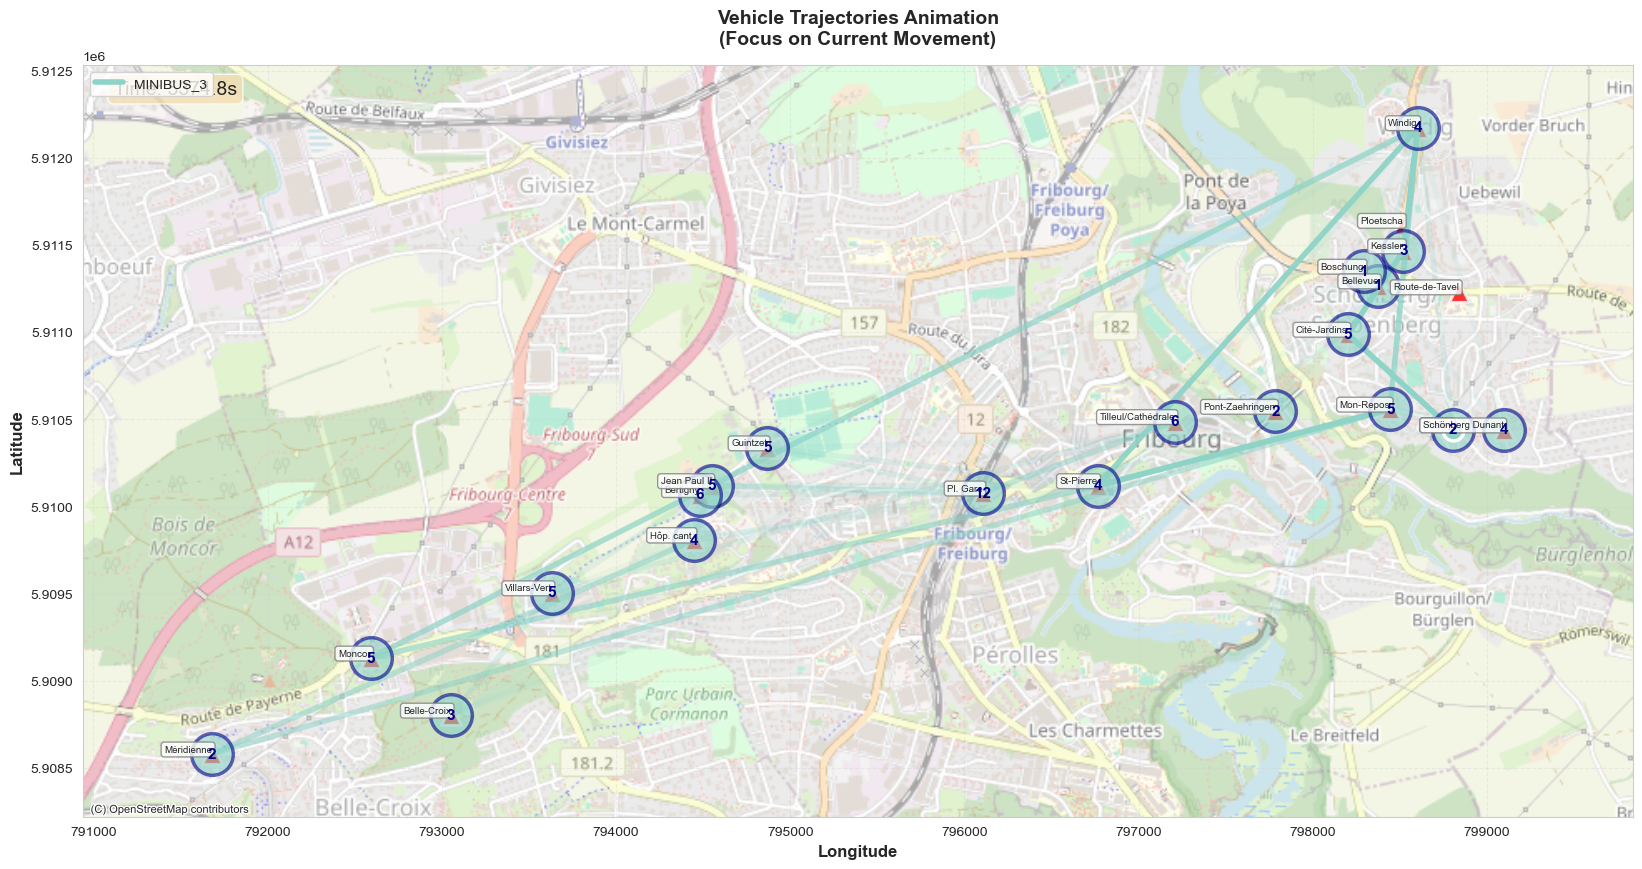


Animation created successfully!
Total frames: 400
Time range: 724.2s - 5374.8s
Total vehicles: 1
Fade duration: 100 frames


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point, LineString
from matplotlib.patches import FancyBboxPatch, Circle
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# Create mapping dictionary from station_id to coordinates
station_coords = {s['station_id']: {'lat': s['location'][0], 'lon': s['location'][1], 'name': s['name']} 
                  for s in station_data['stations']}

# Load vehicle trajectory data
df = pd.read_csv('results/vehicle_states.csv')

# ============ Vehicle Filter Options ============
FILTER_MODE = 'specific'  # 'all', 'minibus_only', 'specific'
SPECIFIC_VEHICLES = ['MINIBUS_3']  # Specify vehicle IDs
FADE_DURATION = 100  # Number of frames for trajectory to fade (higher = slower fade)
SAVE_AS_GIF = True  # Save animation as GIF

# Apply vehicle filter
all_vehicles = df['vehicle_id'].unique()

if FILTER_MODE == 'minibus_only':
    vehicles = [v for v in all_vehicles if 'MINIBUS' in v]
    print(f"Displaying MINIBUS vehicles: {vehicles}")
elif FILTER_MODE == 'specific':
    vehicles = [v for v in SPECIFIC_VEHICLES if v in all_vehicles]
    print(f"Displaying specific vehicles: {vehicles}")
    if len(vehicles) == 0:
        print(f"Warning: Specified vehicles not found. Available vehicles: {list(all_vehicles)}")
else:
    vehicles = all_vehicles
    print(f"Displaying all vehicles: {list(vehicles)}")

# Filter dataframe to selected vehicles
df = df[df['vehicle_id'].isin(vehicles)].copy()

if len(vehicles) == 0:
    print("Error: No vehicles to display!")
    exit()

# Map station IDs to coordinates
df['lat'] = df['location'].map(lambda x: station_coords.get(str(x), {}).get('lat'))
df['lon'] = df['location'].map(lambda x: station_coords.get(str(x), {}).get('lon'))

# Remove rows without valid coordinates
df = df.dropna(subset=['lat', 'lon'])

# Create GeoDataFrame for stations
station_points = []
station_names = []
station_ids = []
for station_id, info in station_coords.items():
    station_points.append(Point(info['lon'], info['lat']))
    station_names.append(info['name'])
    station_ids.append(station_id)

stations_gdf = gpd.GeoDataFrame({
    'station_id': station_ids,
    'name': station_names,
    'geometry': station_points
}, crs='EPSG:4326')

# Convert to Web Mercator for contextily
stations_gdf = stations_gdf.to_crs('EPSG:3857')

# Color mapping for different vehicle types
colors = {}
for vehicle in vehicles:
    if 'MINIBUS' in vehicle:
        colors[vehicle] = plt.cm.Set3(len(colors) % 12)
    else:
        colors[vehicle] = plt.cm.Set1(len(colors) % 9)

# Prepare animation data
vehicle_trajectories = {}
for vehicle in vehicles:
    arrival_data = df[(df['vehicle_id'] == vehicle) & (df['type'] == 'ARRIVAL')].sort_values('time')
    if len(arrival_data) > 0:
        points = [Point(lon, lat) for lon, lat in zip(arrival_data['lon'].values, arrival_data['lat'].values)]
        points_gdf = gpd.GeoDataFrame({'geometry': points, 'time': arrival_data['time'].values}, crs='EPSG:4326')
        points_gdf = points_gdf.to_crs('EPSG:3857')
        vehicle_trajectories[vehicle] = points_gdf

# Calculate passenger counts with station information
vehicle_occupancy = {}
for vehicle in vehicles:
    vehicle_data = df[df['vehicle_id'] == vehicle].sort_values('time')
    current_passengers = 0
    occupancy_records = []
    
    for idx, row in vehicle_data.iterrows():
        if row['type'] == 'BOARDING' and pd.notna(row['count']):
            current_passengers += int(row['count'])
            point = Point(row['lon'], row['lat'])
            point_gdf = gpd.GeoDataFrame({'geometry': [point]}, crs='EPSG:4326')
            point_gdf = point_gdf.to_crs('EPSG:3857')
            occupancy_records.append({
                'time': row['time'],
                'point': point_gdf.geometry.iloc[0],
                'passengers': current_passengers,
                'station_id': str(row['location']),
                'event_type': 'BOARDING'
            })
        elif row['type'] == 'ALIGHTING' and pd.notna(row['count']):
            current_passengers -= int(row['count'])
            point = Point(row['lon'], row['lat'])
            point_gdf = gpd.GeoDataFrame({'geometry': [point]}, crs='EPSG:4326')
            point_gdf = point_gdf.to_crs('EPSG:3857')
            occupancy_records.append({
                'time': row['time'],
                'point': point_gdf.geometry.iloc[0],
                'passengers': current_passengers,
                'station_id': str(row['location']),
                'event_type': 'ALIGHTING'
            })
    
    vehicle_occupancy[vehicle] = occupancy_records

# Get time range and create more frames for smoother animation
all_times = df['time'].values
time_min = all_times.min()
time_max = all_times.max()
time_steps = np.linspace(time_min, time_max, 400)  # More frames for smoother drawing

# Create figure
fig, ax = plt.subplots(figsize=(20, 16))

# Initialize plot elements - use LineCollection for fading effect
line_collections = {}
vehicle_markers = {}
occupancy_scatter = {}
occupancy_texts = {}
segment_frames = {}  # Track when each segment was drawn

for vehicle in vehicles:
    line_collections[vehicle] = None
    vehicle_markers[vehicle], = ax.plot([], [], 'o', markersize=15, color=colors[vehicle], 
                                       markeredgecolor='white', markeredgewidth=2.5, zorder=5)
    occupancy_scatter[vehicle] = None
    occupancy_texts[vehicle] = []
    segment_frames[vehicle] = []

# Plot static elements (stations)
stations_gdf.plot(ax=ax, color='red', markersize=200, alpha=0.8, 
                 edgecolor='white', linewidth=2, zorder=2, marker='^')

# Add station labels
for idx, row in stations_gdf.iterrows():
    name_parts = row['name'].split(',')
    short_name = name_parts[-1].strip() if len(name_parts) > 1 else row['name']
    ax.text(row.geometry.x, row.geometry.y, short_name, 
           fontsize=7, ha='right', va='bottom',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                    edgecolor='gray', alpha=0.8), zorder=6)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.6)

# Set axis limits
all_x = [point.x for traj in vehicle_trajectories.values() for point in traj.geometry]
all_y = [point.y for traj in vehicle_trajectories.values() for point in traj.geometry]
margin = 0.1
x_range = max(all_x) - min(all_x)
y_range = max(all_y) - min(all_y)
ax.set_xlim(min(all_x) - margin * x_range, max(all_x) + margin * x_range)
ax.set_ylim(min(all_y) - margin * y_range, max(all_y) + margin * y_range)

ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax.set_title('Vehicle Trajectories Animation\n(Focus on Current Movement)', 
            fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='--')

# Legend
legend_elements = [plt.Line2D([0], [0], color=colors[v], linewidth=4, label=v) for v in vehicles]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Time display text
time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, fontsize=14, 
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

def init():
    for vehicle in vehicles:
        vehicle_markers[vehicle].set_data([], [])
    time_text.set_text('')
    return list(vehicle_markers.values()) + [time_text]

def animate(frame):
    current_time = time_steps[frame]
    time_text.set_text(f'Time: {current_time:.1f}s')
    
    for vehicle in vehicles:
        traj = vehicle_trajectories[vehicle]
        
        # Get all points up to current time
        traj_current = traj[traj['time'] <= current_time]
        
        if len(traj_current) > 0:
            # Build segments with fade effect
            segments = []
            alphas = []
            
            for i in range(len(traj_current) - 1):
                seg = [(traj_current.geometry.iloc[i].x, traj_current.geometry.iloc[i].y),
                       (traj_current.geometry.iloc[i+1].x, traj_current.geometry.iloc[i+1].y)]
                segments.append(seg)
                
                # Track when this segment was drawn
                if len(segment_frames[vehicle]) <= i:
                    segment_frames[vehicle].append(frame)
                
                # Calculate fade: newer segments are brighter, older fade out
                frames_since_drawn = frame - segment_frames[vehicle][i]
                alpha = max(0.1, 1.0 - (frames_since_drawn / FADE_DURATION))
                alphas.append(alpha)
            
            # Remove old line collection if exists
            if line_collections[vehicle] is not None:
                line_collections[vehicle].remove()
            
            # Create new line collection with fading
            if segments:
                lc = LineCollection(segments, colors=[colors[vehicle]] * len(segments), 
                                  linewidths=4, zorder=3)
                lc.set_alpha(None)  # Allow per-segment alpha
                
                # Set individual alphas for each segment
                segment_colors = [(*colors[vehicle][:3], alpha) for alpha in alphas]
                lc.set_color(segment_colors)
                
                line_collections[vehicle] = ax.add_collection(lc)
            
            # Update current vehicle position (always bright)
            vehicle_markers[vehicle].set_data([traj_current.geometry.iloc[-1].x], 
                                            [traj_current.geometry.iloc[-1].y])
            
            # Update occupancy - only show LATEST at current station
            occupancy_records = vehicle_occupancy[vehicle]
            current_occupancy = [rec for rec in occupancy_records if rec['time'] <= current_time]
            
            # Group by station and keep only the latest record for each station
            station_latest = {}
            for rec in current_occupancy:
                station_id = rec['station_id']
                if station_id not in station_latest or rec['time'] > station_latest[station_id]['time']:
                    station_latest[station_id] = rec
            
            # Clear previous occupancy markers and texts
            if occupancy_scatter[vehicle] is not None:
                occupancy_scatter[vehicle].remove()
                occupancy_scatter[vehicle] = None
            
            for txt in occupancy_texts[vehicle]:
                txt.remove()
            occupancy_texts[vehicle] = []
            
            # Plot only latest occupancy at each station
            if station_latest:
                latest_records = list(station_latest.values())
                occupancy_positions = np.array([[rec['point'].x, rec['point'].y] for rec in latest_records])
                
                occupancy_scatter[vehicle] = ax.scatter(
                    occupancy_positions[:, 0], occupancy_positions[:, 1],
                    s=900, color=colors[vehicle], alpha=0.6, 
                    edgecolors='darkblue', linewidths=2.5, zorder=4
                )
                
                # Add texts for latest occupancy
                for rec in latest_records:
                    txt = ax.text(rec['point'].x, rec['point'].y, str(rec['passengers']), 
                                fontsize=11, fontweight='bold', ha='center', va='center',
                                color='darkblue', zorder=7)
                    occupancy_texts[vehicle].append(txt)
        else:
            # Reset if no trajectory yet
            if line_collections[vehicle] is not None:
                line_collections[vehicle].remove()
                line_collections[vehicle] = None
            vehicle_markers[vehicle].set_data([], [])
            if occupancy_scatter[vehicle] is not None:
                occupancy_scatter[vehicle].remove()
                occupancy_scatter[vehicle] = None
            for txt in occupancy_texts[vehicle]:
                txt.remove()
            occupancy_texts[vehicle] = []
    
    artists = list(vehicle_markers.values()) + [time_text]
    artists += [lc for lc in line_collections.values() if lc is not None]
    artists += [sc for sc in occupancy_scatter.values() if sc is not None]
    return artists

# Create animation
print("Creating animation...")
anim = FuncAnimation(fig, animate, init_func=init, frames=len(time_steps), 
                    interval=40, blit=False, repeat=True)

if SAVE_AS_GIF:
    print("Saving animation as GIF (this may take a while)...")
    writer = PillowWriter(fps=25)
    anim.save('vehicle_animation_fade.gif', writer=writer)
    print("Animation saved as 'vehicle_animation_fade.gif'")

plt.show()

print("\n" + "="*60)
print("Animation created successfully!")
print(f"Total frames: {len(time_steps)}")
print(f"Time range: {time_min:.1f}s - {time_max:.1f}s")
print(f"Total vehicles: {len(vehicles)}")
print(f"Fade duration: {FADE_DURATION} frames")
print("="*60)

In [ ]:
df

vehicle_id         time       type  occupancy  location  count        lat  \
0    MINIBUS_3   724.200012    ARRIVAL          1   8577786    NaN  46.800093   
1    MINIBUS_3   724.200012   BOARDING          1   8577786    1.0  46.800093   
2    MINIBUS_3   996.000000    ARRIVAL          2   8592378    NaN  46.803875   
3    MINIBUS_3   996.000000   BOARDING          2   8592378    1.0  46.803875   
4    MINIBUS_3  1010.400024    ARRIVAL          6   8589161    NaN  46.803873   
..         ...          ...        ...        ...       ...    ...        ...   
205  MINIBUS_3  5372.399994   BOARDING          5   8589138    2.0  46.809219   
206  MINIBUS_3  5372.399994    ARRIVAL          4   8589138    NaN  46.809219   
207  MINIBUS_3  5372.399994  ALIGHTING          4   8589138    1.0  46.809219   
208  MINIBUS_3  5374.800003    ARRIVAL          2   8589141    NaN  46.805855   
209  MINIBUS_3  5374.800003  ALIGHTING          2   8589141    2.0  46.805855   

          lon  
0    7.129319  
1    7.129319  
2    7.137564  
3    7.137564  
4    7.157458  
..        ...  
205  7.170362  
206  7.170362  
207  7.170362  
208  7.175769  
209  7.175769  

[210 rows x 8 columns]

In [ ]:
station_data

{'stations': [{'station_id': '8589141',
   'name': 'Fribourg, Chaley',
   'location': [46.805855, 7.175769],
   'index': 0},
  {'station_id': '8589152',
   'name': 'Fribourg, Mon-Repos',
   'location': [46.806576, 7.172542],
   'index': 1},
  {'station_id': '8589138',
   'name': 'Fribourg, Cité-Jardins',
   'location': [46.809219, 7.170362],
   'index': 2},
  {'station_id': '8591766',
   'name': 'Fribourg, Boschung',
   'location': [46.811443, 7.171201],
   'index': 3},
  {'station_id': '8587255',
   'name': 'Fribourg, Tilleul/Cathédrale',
   'location': [46.806136, 7.161448],
   'index': 4},
  {'station_id': '8589161',
   'name': 'Fribourg, St-Pierre',
   'location': [46.803873, 7.157458],
   'index': 5},
  {'station_id': '8592374',
   'name': 'Fribourg/Freiburg, Pl. Gare',
   'location': [46.803615, 7.151538],
   'index': 6},
  {'station_id': '8589130',
   'name': 'Villars-sur-Glâne, Méridienne',
   'location': [46.794403, 7.111792],
   'index': 7},
  {'station_id': '8589131',
   'na